# Tel-Aviv Deep Learning Boot-camp: 12 Applied Deep Learning Labs

## Lab 0: Plant Seedlings Classification (PyTorch): The most basic lab :)  

<img src="assets/seedlings.png" align="center">

### Instructors:

- Shlomo Kashani: shlomo@bayesian.io ,
- Nathaniel Shimoni nathaniel.shimoni@grid4c.com 

<img src="assets/pt.jpg" width="35%" align="center">

## Progress

- [x] PyTorch DataSet
- [x] PyTorch DataLoader
- [x] Augmentations
- [x] Simple CNN
- [x] Training + train test split
- [x] TensorBoard Support from PyTorch
- [x] Accuray and Log Loss
- [x] Tqdm progress
- [x] Persisting the model
- [x] Testing on a test set



### Links:

- https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/ 
- Git: https://github.com/bayesianio/applied-dl-2018
- Full info: https://www.evernote.com/shard/s341/sh/3855640e-2b0b-42e5-b5b9-00216d02ac9a/b47968226e49a81ee813901cd41d3924

### Date and Location: 
- July 2018


### Requirements:
- Python 3.5, CUDA 9, cuDNN 7, PyTorch 2.0 or above, Keras 2 or above

#### For Windows 10 and Windows Server 2016, CUDA 9
`conda install -c peterjc123 pytorch cuda90`


### Data
- Download: https://www.kaggle.com/c/plant-seedlings-classification

- Please make sure you have already set up a Pytorch tree structure of your dataset:
- `data_dir= '/home/data/bone/train/' `

```
    data_dir= '/home/data/bone/train/
    
    ├── valid
    │   └── Type_1
        ├── Type_2
        └── Type_3
    └── train
        ├── Type_1
        ├── Type_2
        └── Type_3
```

### PyTorch Datasets

To create a dataset, we subclass Dataset and define a constructor, a `__len__` method, and a `__getitem__` method. 
Here is full example:

```python
class BoneDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0] # file name
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2] # category_id
        if self.transform:
            image = self.transform(image)
        return image, labels
```

### The PyTorch DataLoader Class¶
- Will load our BoneDataset
- Can be regarded as a list (or iterator, technically).
- Each time it is invoked will provide a minibatch of (img, label) pairs.


### Training with TensorBoard

With the aid of [Crayon](https://github.com/torrvision/crayon),
we can access the visualisation power of TensorBoard for any 
deep learning framework.

To use the TensorBoard, install Crayon (https://github.com/torrvision/crayon)
and set `use_tensorboard = True`


## Google Colab links:
- https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
- https://jovianlin.io/pytorch-with-gpu-in-google-colab/

In [1]:
# Google specific code

# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
# !pip3 install torchvision
# !pip3 install tqdm

# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# !mkdir -p med-drive
# !google-drive-ocamlfuse med-drive

In [14]:
%reset -f 
%matplotlib inline


import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 


import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = 2222
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)



__Python VERSION: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
__pyTorch VERSION: 0.3.1.post2
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:32_Central_Daylight_Time_2017
Cuda compilation tools, release 9.0, V9.0.176
__CUDNN VERSION: 7003
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
USE CUDA=True


In [15]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from kmodels import *
from kdataset import *

### Define Custom Dataset

In [16]:
import os
dataset='seedlings' # bone , cat-dog   d:/db/data/cat-dog/train/ ISIC2017
data_dir= 'd:/db/data/' +  dataset + '/train/'
# data_dir_valid= 'd:/db/data/' +  dataset + '/valid/'

classes, class_to_idx, num_to_class, df =GenericDataset.find_classes (data_dir )

print (classes)
print (class_to_idx)
print (num_to_class)
df.head(5)    

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}


,file,category,category_id
0,Black-grass/0050f38b3.png,Black-grass,0
1,Black-grass/0183fdf68.png,Black-grass,0
2,Black-grass/0260cffa8.png,Black-grass,0
3,Black-grass/05eedce4d.png,Black-grass,0
4,Black-grass/075d004bc.png,Black-grass,0


In [17]:
len(classes)

12

# Target distribution : Train set

c:\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


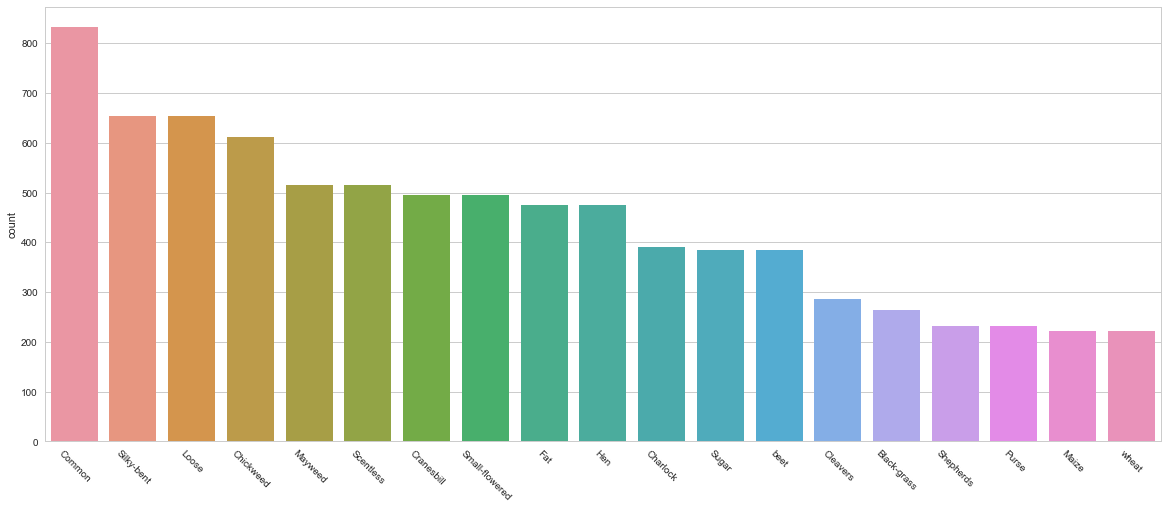

In [18]:
import seaborn as sns
sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

labels = df['category'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(20,8)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45);

# Augmentation 

In [19]:
from __future__ import absolute_import

from torchvision.transforms import *

from PIL import Image, ImageDraw
import numpy as np
import torch

import torchvision
import random
from PIL import Image, ImageOps
import numpy as np
import numbers
import math
import torch
import torch
import random
import PIL.ImageEnhance as ie
import PIL.Image as im

# adapted from https://github.com/kuangliu/pytorch-retinanet/blob/master/transform.py
# https://github.com/mratsim/Amazon-Forest-Computer-Vision/blob/master/src/p_data_augmentation.py

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

from ktransforms import *

## Setup transforms, datasets, and dataloaders

- Data loaders spit out data from a dataset in batches. This is what you actually feed the neural network during training.

{'train': 4038, 'valid': 712}
6     566
3     513
8     445
10    421
5     408
1     327
11    316
2     247
0     225
9     202
7     185
4     183
Name: category_id, dtype: int64


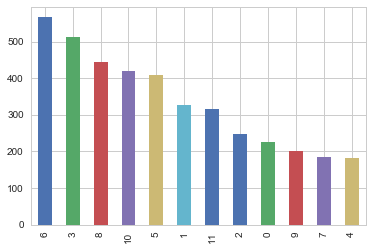

In [20]:
image_size = 224

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomSizedCrop(image_size),
    PowerPIL(),
    transforms.ToTensor(),
#     normalize_img,
    RandomErasing()
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     normalize_img
])

batch_size = 8
train_data = df.sample(frac=0.85)
valid_data = df[~df['file'].isin(train_data['file'])]

train_set = GenericDataset(train_data, data_dir, transform = train_trans)
valid_set = GenericDataset(valid_data, data_dir, transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
v_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
# test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset)
}


print (dataset_sizes)
print (train_data["category_id"].value_counts())

train_data['category_id'].value_counts().plot(kind='bar')

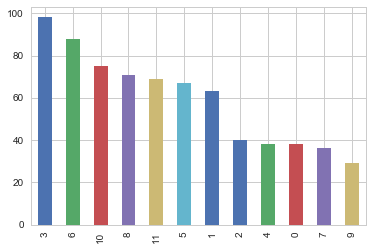

In [21]:
valid_data['category_id'].value_counts().plot(kind='bar')

### Test the DataLoader Class

i=0: 
i=1: 
i=2: 
i=3: 


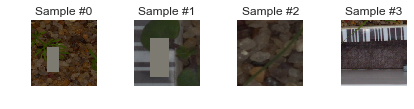

In [22]:
imagesToShow=4

def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    

if __name__ == '__main__':  
    for i, data in enumerate(t_loader, 0):
        print('i=%d: '%(i))            
        images, labels = data            
        num = len(images)

        ax = plt.subplot(1, imagesToShow, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')

        for n in range(num):
            image=images[n]
            label=labels[n]
            plt.imshow (flaotTensorToImage(image))

        if i==imagesToShow-1:
            break

## Define the model
- A simple CNN with great performance (95% accuracy) 
- In PyTorch, a model is defined by a subclass of nn.Module. It has two methods:

`__init__:` constructor. Create layers here. Note that we don't define the connections between layers in this function.

`forward(x):` forward function. Receives an input variable x. Returns a output variable. Note that we actually connect the layers here dynamically.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np

# model = SimpleNet(len(classes), 3)
# model =vggnetXX_generic(len(classes), 3)
# model =lenetXX_generic(len(classes), 3)
# model =resnetxtXX_generic(len(classes), 3)
# model =wrnXX_generic(len(classes), 3)
model =dpn92(len(classes))
# model = senetXX_generic(len(classes), 3, 32)


criterion = torch.nn.CrossEntropyLoss()
lr= 0.00005 * 2 * 2
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

if use_cuda:
    model = model.cuda()
# model = senetXX_generic(len(classes), 3, 32)
model_name = (type(model).__name__) # remember the real name
# model = torch.nn.DataParallel(model, device_ids=list(range(4)))
print(model)

DPN(
  (features): Sequential(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    )
    (conv2_1): DualPathBlock(
      (c1x1_w): Sequential(
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv): Conv2d(64, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (layers): Sequential(
        (c1x1_a): Sequential(
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU(inplace)
          (conv): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (c3x3_b): Sequential(
          (norm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU(inplace)
          (conv): Conv2

)


# Metrics and Tensorboard

In [24]:
import datetime 

from utils import *

NOW_TIME = datetime.datetime.now()
NOW_TIME =NOW_TIME.strftime("%Y-%m-%d %H:%M")

use_tensorboard=False

hms_string(1000)

'0:16:40.00'

### Training

In [25]:
from tqdm import tqdm 
from sklearn import metrics
import torch
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

def train(train_loader, model, epoch, optimizer):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
   
    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (images, target) in enumerate(train_loader): 
        correct = 0
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            images, target = images.cuda(), target.cuda()
            images, target = Variable(images), Variable(target)
        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, target)

        # measure accuracy and record loss
        prec1, prec1 = accuracy2(y_pred.data, target.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))
        
        pred = y_pred.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 200  == 0:
            print('TRAIN: LOSS-->{loss.val:.4f} ({loss.avg:.4f})\t' 'ACC-->{acc.val:.3f}% ({acc.avg:.3f}%)'.format(loss=losses, acc=acc))
            if use_tensorboard:
                exp.add_scalar_value('tr_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('tr_epoch_acc', acc.avg, step=epoch)
                
            print('TRAIN: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.3f}%)'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0],
                correct, len(images),
                accuracy))            
    

    return float('{loss.avg:.4f}'.format(loss=losses)), float('{acc.avg:.4f}'.format(acc=acc))

def validate(val_loader, model, epoch):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            images, labels = Variable(images, volatile=True), Variable(labels)

        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # measure accuracy and record loss
        prec1, temp_var = accuracy2(y_pred.data, labels.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 200== 0:
            print('VAL:   LOSS--> {loss.val:.4f} ({loss.avg:.4f})\t''ACC-->{acc.val:.3f} ({acc.avg:.3f})'.format(loss=losses, acc=acc))

        if i % 50 == 0:
            if use_tensorboard:
                exp.add_scalar_value('val_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('val_epoch_acc', acc.avg, step=epoch)

    print(' * Accuracy {acc.avg:.4f}'.format(acc=acc))
    return float('{loss.avg:.6f}'.format(loss=losses)), float('{acc.avg:.6f}'.format(acc=acc))


def testImageLoader(image_name):
    """load image, returns cuda tensor"""
#     image = Image.open(image_name)
    image = Image.open(image_name).convert('RGB')
    image = test_trans(image)
#     image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    if use_cuda:
#         print ("cuda")
        image.cuda()         
    return image  

def testModel(test_dir, local_model):    
    if use_cuda:
        local_model.cuda()
    
    local_model.eval()
    
    columns = ['file', 'species']
    df_pred = pd.DataFrame(data=np.zeros((0, len(columns))), columns=columns)
#     df_pred.species.astype(int)
    for index, row in (sample_submission.iterrows()):
#         for file in os.listdir(test_dir):            
        currImage=os.path.join(test_dir, row['file'])
        if os.path.isfile(currImage):
            X_tensor_test=testImageLoader (currImage)            
#             print (type(X_tensor_test))
            if use_cuda:
                X_tensor_test = Variable(X_tensor_test.cuda()) 
            else:
                X_tensor_test = Variable(X_tensor_test)        
            
            # get the index of the max log-probability
            predicted_val = (local_model(X_tensor_test)).data.max(1)[1] # get the index of the max log-probability
#             predicted_val = predicted_val.data.max(1, keepdim=True)[1]
            p_test = (predicted_val.cpu().numpy().item())
            df_pred = df_pred.append({'file': row['file'], 'species': num_to_class[int(p_test)]}, ignore_index=True)             
    
    return df_pred

### Train the model

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.columns = ['file', 'species']
# sample_submission['category_id'] = 0
sample_submission.head(3)

test_trans = valid_trans
test_data_dir = 'd:/db/data/seedlings/test/'

if __name__ == '__main__':  
    epochs=220
    runId = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')    
    recorder = RecorderMeter(epochs)  # epoc is updated
#     model_name = (type(model).__name__)

    exp_name = datetime.datetime.now().strftime(model_name + '_' + dataset + '_%Y-%m-%d_%H-%M-%S')    
    mPath = './logs' + '/' + dataset + '/' + model_name + '/'    
    if not os.path.isdir(mPath):
        os.makedirs(mPath)    
    print("Random Seed: {}".format(manualSeed))
    print("python version : {}".format(sys.version.replace('\n', ' ')))
    print("torch  version : {}".format(torch.__version__))
    print("cudnn  version : {}".format(torch.backends.cudnn.version()))    
    print("=> Final model name '{}'".format(model_name))            
    print ("MODEL: {}".format( str(model_name)))
    print ("dataset: {}".format(dataset))
    print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))    
    
    print ("MODEL: {}".format( str(type(model).__name__)))
    
    start_training_time = time.time()
    training_time=time.time()
    for epoch in tqdm(range(0, epochs)):        
        train_result, accuracy_tr=train(t_loader, model, epoch, optimizer)
        val_loss, val_accuracy= validate(v_loader, model, epoch)  
        
        recorder.update(epoch, train_result, accuracy_tr, val_loss, val_accuracy) 
        training_time=time.time() - start_training_time
        recorder.plot_curve(os.path.join(mPath, model_name + '_' + exp_name + '.png'),training_time, model, model_name,
                            str(dataset_sizes),
                        batch_size, lr,dataset,manualSeed,len(classes))
        
        if float(val_accuracy) > float(98.0):            
            print ("EARLY STOP")            
            df_pred=testModel(test_data_dir,model)
            df_pred.to_csv(str(type(model).__name__) + '_' + str(val_accuracy) + '_' + 
                           str(epoch) + "_sub.csv", columns=('file', 'species'), index=None)
            torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + '_.pth'))                        

Random Seed: 2222
python version : 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
torch  version : 0.3.1.post2
cudnn  version : 7003
=> Final model name 'DPN'
MODEL: DPN
dataset: seedlings
    Total params: 35.01M
MODEL: DPN


  0%|                                                                                                                                                           | 0/220 [00:00<?, ?it/s]

TRAIN: LOSS-->2.4876 (2.4876)	ACC-->0.000% (0.000%)
TRAIN: 0 [0/4038 (0%)]	Loss: 2.487592, Accuracy: 0/8 (0.000%)
TRAIN: LOSS-->2.1794 (2.4797)	ACC-->25.000% (16.915%)
TRAIN: 0 [1600/4038 (40%)]	Loss: 2.179369, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.8762 (2.3380)	ACC-->25.000% (20.667%)
TRAIN: 0 [3200/4038 (79%)]	Loss: 1.876172, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 1.8210 (1.8210)	ACC-->37.500 (37.500)
 * Accuracy 31.4607


  0%|▋                                                                                                                                               | 1/220 [02:40<9:44:47, 160.21s/it]

TRAIN: LOSS-->2.8310 (2.8310)	ACC-->12.500% (12.500%)
TRAIN: 1 [0/4038 (0%)]	Loss: 2.830983, Accuracy: 1/8 (12.500%)
TRAIN: LOSS-->1.8975 (2.0213)	ACC-->37.500% (31.032%)
TRAIN: 1 [1600/4038 (40%)]	Loss: 1.897545, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.6882 (1.9702)	ACC-->50.000% (33.292%)
TRAIN: 1 [3200/4038 (79%)]	Loss: 1.688155, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 1.0810 (1.0810)	ACC-->62.500 (62.500)
 * Accuracy 41.7135


  1%|█▎                                                                                                                                              | 2/220 [05:18<9:39:19, 159.45s/it]

TRAIN: LOSS-->2.7716 (2.7716)	ACC-->12.500% (12.500%)
TRAIN: 2 [0/4038 (0%)]	Loss: 2.771613, Accuracy: 1/8 (12.500%)
TRAIN: LOSS-->2.1086 (1.8379)	ACC-->37.500% (36.505%)
TRAIN: 2 [1600/4038 (40%)]	Loss: 2.108582, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->2.0125 (1.8215)	ACC-->25.000% (37.531%)
TRAIN: 2 [3200/4038 (79%)]	Loss: 2.012476, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 1.2555 (1.2555)	ACC-->62.500 (62.500)
 * Accuracy 53.7921


  1%|█▉                                                                                                                                              | 3/220 [07:57<9:35:51, 159.22s/it]

TRAIN: LOSS-->1.5207 (1.5207)	ACC-->25.000% (25.000%)
TRAIN: 3 [0/4038 (0%)]	Loss: 1.520744, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.4634 (1.6676)	ACC-->50.000% (42.724%)
TRAIN: 3 [1600/4038 (40%)]	Loss: 1.463439, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.9793 (1.6502)	ACC-->75.000% (43.890%)
TRAIN: 3 [3200/4038 (79%)]	Loss: 0.979265, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 1.0562 (1.0562)	ACC-->50.000 (50.000)
 * Accuracy 57.0225


  2%|██▌                                                                                                                                             | 4/220 [10:36<9:32:49, 159.12s/it]

TRAIN: LOSS-->1.2748 (1.2748)	ACC-->62.500% (62.500%)
TRAIN: 4 [0/4038 (0%)]	Loss: 1.274846, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->2.0716 (1.5953)	ACC-->37.500% (44.341%)
TRAIN: 4 [1600/4038 (40%)]	Loss: 2.071552, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.4450 (1.5777)	ACC-->62.500% (45.480%)
TRAIN: 4 [3200/4038 (79%)]	Loss: 1.445018, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 1.3914 (1.3914)	ACC-->62.500 (62.500)
 * Accuracy 59.8315


  2%|███▎                                                                                                                                            | 5/220 [13:14<9:29:44, 159.00s/it]

TRAIN: LOSS-->1.3404 (1.3404)	ACC-->50.000% (50.000%)
TRAIN: 5 [0/4038 (0%)]	Loss: 1.340355, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.8233 (1.4606)	ACC-->25.000% (48.694%)
TRAIN: 5 [1600/4038 (40%)]	Loss: 1.823300, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.1691 (1.4411)	ACC-->50.000% (49.751%)
TRAIN: 5 [3200/4038 (79%)]	Loss: 1.169054, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.6989 (0.6989)	ACC-->87.500 (87.500)
 * Accuracy 64.1854


  3%|███▉                                                                                                                                            | 6/220 [15:53<9:26:41, 158.89s/it]

TRAIN: LOSS-->0.9702 (0.9702)	ACC-->62.500% (62.500%)
TRAIN: 6 [0/4038 (0%)]	Loss: 0.970168, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1699 (1.3441)	ACC-->50.000% (54.104%)
TRAIN: 6 [1600/4038 (40%)]	Loss: 1.169942, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.9112 (1.3153)	ACC-->75.000% (54.738%)
TRAIN: 6 [3200/4038 (79%)]	Loss: 0.911197, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 1.2636 (1.2636)	ACC-->62.500 (62.500)
 * Accuracy 65.0281


  3%|████▌                                                                                                                                           | 7/220 [18:31<9:23:51, 158.83s/it]

TRAIN: LOSS-->1.7077 (1.7077)	ACC-->50.000% (50.000%)
TRAIN: 7 [0/4038 (0%)]	Loss: 1.707706, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->2.2554 (1.2211)	ACC-->25.000% (59.017%)
TRAIN: 7 [1600/4038 (40%)]	Loss: 2.255445, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->1.9064 (1.2368)	ACC-->37.500% (58.074%)
TRAIN: 7 [3200/4038 (79%)]	Loss: 1.906396, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 0.1512 (0.1512)	ACC-->100.000 (100.000)
 * Accuracy 74.7191


  4%|█████▏                                                                                                                                          | 8/220 [21:09<9:20:51, 158.74s/it]

TRAIN: LOSS-->0.5032 (0.5032)	ACC-->87.500% (87.500%)
TRAIN: 8 [0/4038 (0%)]	Loss: 0.503199, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3627 (1.1634)	ACC-->100.000% (61.381%)
TRAIN: 8 [1600/4038 (40%)]	Loss: 0.362664, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.0700 (1.1451)	ACC-->50.000% (61.908%)
TRAIN: 8 [3200/4038 (79%)]	Loss: 1.069963, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 1.1663 (1.1663)	ACC-->75.000 (75.000)
 * Accuracy 76.1236


  4%|█████▉                                                                                                                                          | 9/220 [23:48<9:18:11, 158.73s/it]

TRAIN: LOSS-->1.1870 (1.1870)	ACC-->62.500% (62.500%)
TRAIN: 9 [0/4038 (0%)]	Loss: 1.187040, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->2.2966 (1.1651)	ACC-->25.000% (60.945%)
TRAIN: 9 [1600/4038 (40%)]	Loss: 2.296613, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->0.7222 (1.1183)	ACC-->75.000% (61.596%)
TRAIN: 9 [3200/4038 (79%)]	Loss: 0.722152, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.3919 (0.3919)	ACC-->87.500 (87.500)
 * Accuracy 77.2472


  5%|██████▌                                                                                                                                        | 10/220 [26:27<9:15:33, 158.73s/it]

TRAIN: LOSS-->1.4551 (1.4551)	ACC-->25.000% (25.000%)
TRAIN: 10 [0/4038 (0%)]	Loss: 1.455114, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->0.7128 (1.0018)	ACC-->75.000% (66.107%)
TRAIN: 10 [1600/4038 (40%)]	Loss: 0.712834, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4101 (1.0028)	ACC-->87.500% (66.739%)
TRAIN: 10 [3200/4038 (79%)]	Loss: 0.410130, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 2.1863 (2.1863)	ACC-->62.500 (62.500)
 * Accuracy 71.2079


  5%|███████▏                                                                                                                                       | 11/220 [29:06<9:12:55, 158.73s/it]

TRAIN: LOSS-->1.5684 (1.5684)	ACC-->62.500% (62.500%)
TRAIN: 11 [0/4038 (0%)]	Loss: 1.568399, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.9281 (1.0045)	ACC-->62.500% (65.050%)
TRAIN: 11 [1600/4038 (40%)]	Loss: 0.928113, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.0517 (0.9974)	ACC-->50.000% (65.680%)
TRAIN: 11 [3200/4038 (79%)]	Loss: 1.051731, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.7237 (0.7237)	ACC-->75.000 (75.000)
 * Accuracy 81.1798


  5%|███████▊                                                                                                                                       | 12/220 [31:44<9:10:10, 158.71s/it]

TRAIN: LOSS-->0.9507 (0.9507)	ACC-->75.000% (75.000%)
TRAIN: 12 [0/4038 (0%)]	Loss: 0.950652, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4818 (0.9331)	ACC-->75.000% (67.973%)
TRAIN: 12 [1600/4038 (40%)]	Loss: 0.481806, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.1790 (0.9234)	ACC-->62.500% (68.547%)
TRAIN: 12 [3200/4038 (79%)]	Loss: 1.178977, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.3664 (0.3664)	ACC-->87.500 (87.500)
 * Accuracy 71.9101


  6%|████████▍                                                                                                                                      | 13/220 [34:23<9:07:30, 158.70s/it]

TRAIN: LOSS-->1.0658 (1.0658)	ACC-->62.500% (62.500%)
TRAIN: 13 [0/4038 (0%)]	Loss: 1.065802, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.8818 (0.9136)	ACC-->50.000% (68.532%)
TRAIN: 13 [1600/4038 (40%)]	Loss: 0.881802, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.8210 (0.9162)	ACC-->62.500% (68.392%)
TRAIN: 13 [3200/4038 (79%)]	Loss: 0.821032, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.4501 (0.4501)	ACC-->87.500 (87.500)
 * Accuracy 82.7247


  6%|█████████                                                                                                                                      | 14/220 [37:01<9:04:53, 158.71s/it]

TRAIN: LOSS-->1.2219 (1.2219)	ACC-->75.000% (75.000%)
TRAIN: 14 [0/4038 (0%)]	Loss: 1.221859, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.4146 (0.8367)	ACC-->50.000% (72.388%)
TRAIN: 14 [1600/4038 (40%)]	Loss: 1.414559, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.0058 (0.8549)	ACC-->87.500% (71.072%)
TRAIN: 14 [3200/4038 (79%)]	Loss: 1.005817, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1154 (0.1154)	ACC-->100.000 (100.000)
 * Accuracy 86.0955


  7%|█████████▊                                                                                                                                     | 15/220 [39:40<9:02:10, 158.68s/it]

TRAIN: LOSS-->1.0150 (1.0150)	ACC-->62.500% (62.500%)
TRAIN: 15 [0/4038 (0%)]	Loss: 1.015031, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.2241 (0.8620)	ACC-->50.000% (70.087%)
TRAIN: 15 [1600/4038 (40%)]	Loss: 1.224064, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.6226 (0.8478)	ACC-->75.000% (70.948%)
TRAIN: 15 [3200/4038 (79%)]	Loss: 0.622630, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4759 (0.4759)	ACC-->87.500 (87.500)
 * Accuracy 83.5674


  7%|██████████▍                                                                                                                                    | 16/220 [42:18<8:59:30, 158.68s/it]

TRAIN: LOSS-->0.2623 (0.2623)	ACC-->100.000% (100.000%)
TRAIN: 16 [0/4038 (0%)]	Loss: 0.262262, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3827 (0.8036)	ACC-->100.000% (72.201%)
TRAIN: 16 [1600/4038 (40%)]	Loss: 0.382695, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4776 (0.8006)	ACC-->75.000% (72.319%)
TRAIN: 16 [3200/4038 (79%)]	Loss: 0.477594, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 1.4568 (1.4568)	ACC-->62.500 (62.500)
 * Accuracy 83.2865


  8%|███████████                                                                                                                                    | 17/220 [44:56<8:56:35, 158.60s/it]

TRAIN: LOSS-->1.0967 (1.0967)	ACC-->75.000% (75.000%)
TRAIN: 17 [0/4038 (0%)]	Loss: 1.096667, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2692 (0.7729)	ACC-->87.500% (73.383%)
TRAIN: 17 [1600/4038 (40%)]	Loss: 0.269154, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5624 (0.7767)	ACC-->62.500% (73.473%)
TRAIN: 17 [3200/4038 (79%)]	Loss: 0.562419, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.1509 (0.1509)	ACC-->87.500 (87.500)
 * Accuracy 86.7978


  8%|███████████▋                                                                                                                                   | 18/220 [47:34<8:53:54, 158.59s/it]

TRAIN: LOSS-->0.2461 (0.2461)	ACC-->100.000% (100.000%)
TRAIN: 18 [0/4038 (0%)]	Loss: 0.246105, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.8146 (0.7841)	ACC-->62.500% (73.756%)
TRAIN: 18 [1600/4038 (40%)]	Loss: 0.814622, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.6855 (0.7727)	ACC-->50.000% (74.002%)
TRAIN: 18 [3200/4038 (79%)]	Loss: 1.685504, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 2.2272 (2.2272)	ACC-->75.000 (75.000)
 * Accuracy 86.3764


  9%|████████████▎                                                                                                                                  | 19/220 [50:13<8:51:15, 158.59s/it]

TRAIN: LOSS-->0.4714 (0.4714)	ACC-->75.000% (75.000%)
TRAIN: 19 [0/4038 (0%)]	Loss: 0.471412, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0972 (0.7326)	ACC-->100.000% (74.751%)
TRAIN: 19 [1600/4038 (40%)]	Loss: 0.097229, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6978 (0.7398)	ACC-->87.500% (74.688%)
TRAIN: 19 [3200/4038 (79%)]	Loss: 0.697793, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1831 (0.1831)	ACC-->100.000 (100.000)
 * Accuracy 87.9213


  9%|█████████████                                                                                                                                  | 20/220 [52:51<8:48:36, 158.58s/it]

TRAIN: LOSS-->0.7707 (0.7707)	ACC-->87.500% (87.500%)
TRAIN: 20 [0/4038 (0%)]	Loss: 0.770720, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3477 (0.7528)	ACC-->100.000% (73.756%)
TRAIN: 20 [1600/4038 (40%)]	Loss: 0.347696, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5601 (0.7514)	ACC-->75.000% (73.847%)
TRAIN: 20 [3200/4038 (79%)]	Loss: 0.560067, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1043 (0.1043)	ACC-->100.000 (100.000)
 * Accuracy 85.1124


 10%|█████████████▋                                                                                                                                 | 21/220 [55:30<8:45:57, 158.58s/it]

TRAIN: LOSS-->1.5033 (1.5033)	ACC-->62.500% (62.500%)
TRAIN: 21 [0/4038 (0%)]	Loss: 1.503293, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4670 (0.7370)	ACC-->87.500% (75.560%)
TRAIN: 21 [1600/4038 (40%)]	Loss: 0.466959, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->2.0581 (0.7498)	ACC-->50.000% (74.532%)
TRAIN: 21 [3200/4038 (79%)]	Loss: 2.058067, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.7338 (0.7338)	ACC-->87.500 (87.500)
 * Accuracy 83.5674


 10%|██████████████▎                                                                                                                                | 22/220 [58:08<8:43:16, 158.57s/it]

TRAIN: LOSS-->0.7509 (0.7509)	ACC-->75.000% (75.000%)
TRAIN: 22 [0/4038 (0%)]	Loss: 0.750878, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0479 (0.7723)	ACC-->75.000% (73.259%)
TRAIN: 22 [1600/4038 (40%)]	Loss: 1.047857, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8517 (0.7184)	ACC-->62.500% (75.125%)
TRAIN: 22 [3200/4038 (79%)]	Loss: 0.851660, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.4150 (0.4150)	ACC-->75.000 (75.000)
 * Accuracy 88.4831


 10%|██████████████▋                                                                                                                              | 23/220 [1:00:45<8:40:28, 158.52s/it]

TRAIN: LOSS-->0.7339 (0.7339)	ACC-->87.500% (87.500%)
TRAIN: 23 [0/4038 (0%)]	Loss: 0.733872, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8662 (0.6669)	ACC-->50.000% (76.368%)
TRAIN: 23 [1600/4038 (40%)]	Loss: 0.866202, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.7679 (0.6691)	ACC-->62.500% (76.808%)
TRAIN: 23 [3200/4038 (79%)]	Loss: 0.767851, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.5422 (0.5422)	ACC-->75.000 (75.000)
 * Accuracy 87.2191


 11%|███████████████▍                                                                                                                             | 24/220 [1:03:24<8:37:49, 158.52s/it]

TRAIN: LOSS-->0.3651 (0.3651)	ACC-->87.500% (87.500%)
TRAIN: 24 [0/4038 (0%)]	Loss: 0.365087, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8618 (0.6649)	ACC-->75.000% (77.612%)
TRAIN: 24 [1600/4038 (40%)]	Loss: 0.861804, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4945 (0.6519)	ACC-->87.500% (77.837%)
TRAIN: 24 [3200/4038 (79%)]	Loss: 0.494465, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0369 (0.0369)	ACC-->100.000 (100.000)
 * Accuracy 88.4831


 11%|████████████████                                                                                                                             | 25/220 [1:06:02<8:35:10, 158.51s/it]

TRAIN: LOSS-->0.7208 (0.7208)	ACC-->75.000% (75.000%)
TRAIN: 25 [0/4038 (0%)]	Loss: 0.720845, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7865 (0.5862)	ACC-->62.500% (79.726%)
TRAIN: 25 [1600/4038 (40%)]	Loss: 0.786525, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.2589 (0.6480)	ACC-->62.500% (77.868%)
TRAIN: 25 [3200/4038 (79%)]	Loss: 1.258940, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.6194 (0.6194)	ACC-->87.500 (87.500)
 * Accuracy 83.4270


 12%|████████████████▋                                                                                                                            | 26/220 [1:08:41<8:32:31, 158.51s/it]

TRAIN: LOSS-->0.3341 (0.3341)	ACC-->100.000% (100.000%)
TRAIN: 26 [0/4038 (0%)]	Loss: 0.334062, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1332 (0.6668)	ACC-->100.000% (77.550%)
TRAIN: 26 [1600/4038 (40%)]	Loss: 0.133206, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.4049 (0.6474)	ACC-->50.000% (78.180%)
TRAIN: 26 [3200/4038 (79%)]	Loss: 1.404896, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.1563 (0.1563)	ACC-->100.000 (100.000)
 * Accuracy 89.3258


 12%|█████████████████▎                                                                                                                           | 27/220 [1:11:19<8:29:53, 158.52s/it]

TRAIN: LOSS-->1.3684 (1.3684)	ACC-->75.000% (75.000%)
TRAIN: 27 [0/4038 (0%)]	Loss: 1.368351, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4802 (0.6064)	ACC-->87.500% (79.291%)
TRAIN: 27 [1600/4038 (40%)]	Loss: 0.480216, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5553 (0.6132)	ACC-->87.500% (79.676%)
TRAIN: 27 [3200/4038 (79%)]	Loss: 0.555335, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0119 (0.0119)	ACC-->100.000 (100.000)
 * Accuracy 90.1685


 13%|█████████████████▉                                                                                                                           | 28/220 [1:13:58<8:27:13, 158.51s/it]

TRAIN: LOSS-->0.7362 (0.7362)	ACC-->87.500% (87.500%)
TRAIN: 28 [0/4038 (0%)]	Loss: 0.736203, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5797 (0.6161)	ACC-->75.000% (78.545%)
TRAIN: 28 [1600/4038 (40%)]	Loss: 0.579736, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4981 (0.6077)	ACC-->75.000% (78.897%)
TRAIN: 28 [3200/4038 (79%)]	Loss: 0.498088, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0686 (0.0686)	ACC-->100.000 (100.000)
 * Accuracy 88.4831


 13%|██████████████████▌                                                                                                                          | 29/220 [1:16:36<8:24:30, 158.49s/it]

TRAIN: LOSS-->1.0864 (1.0864)	ACC-->62.500% (62.500%)
TRAIN: 29 [0/4038 (0%)]	Loss: 1.086436, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.5384 (0.6192)	ACC-->75.000% (77.923%)
TRAIN: 29 [1600/4038 (40%)]	Loss: 0.538437, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3111 (0.6110)	ACC-->87.500% (78.772%)
TRAIN: 29 [3200/4038 (79%)]	Loss: 0.311078, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0313 (0.0313)	ACC-->100.000 (100.000)
 * Accuracy 90.4494


 14%|███████████████████▏                                                                                                                         | 30/220 [1:19:14<8:21:51, 158.48s/it]

TRAIN: LOSS-->0.3601 (0.3601)	ACC-->87.500% (87.500%)
TRAIN: 30 [0/4038 (0%)]	Loss: 0.360064, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0580 (0.5852)	ACC-->100.000% (80.037%)
TRAIN: 30 [1600/4038 (40%)]	Loss: 0.058009, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3554 (0.5974)	ACC-->87.500% (79.769%)
TRAIN: 30 [3200/4038 (79%)]	Loss: 0.355421, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1567 (0.1567)	ACC-->87.500 (87.500)
 * Accuracy 91.4326


 14%|███████████████████▊                                                                                                                         | 31/220 [1:21:52<8:19:13, 158.48s/it]

TRAIN: LOSS-->0.7845 (0.7845)	ACC-->75.000% (75.000%)
TRAIN: 31 [0/4038 (0%)]	Loss: 0.784500, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1038 (0.5976)	ACC-->100.000% (79.913%)
TRAIN: 31 [1600/4038 (40%)]	Loss: 0.103761, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3827 (0.5729)	ACC-->87.500% (80.330%)
TRAIN: 31 [3200/4038 (79%)]	Loss: 0.382701, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2447 (0.2447)	ACC-->87.500 (87.500)
 * Accuracy 89.4663


 15%|████████████████████▌                                                                                                                        | 32/220 [1:24:31<8:16:34, 158.48s/it]

TRAIN: LOSS-->0.2890 (0.2890)	ACC-->100.000% (100.000%)
TRAIN: 32 [0/4038 (0%)]	Loss: 0.288984, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6913 (0.5502)	ACC-->75.000% (80.908%)
TRAIN: 32 [1600/4038 (40%)]	Loss: 0.691340, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.6745 (0.5750)	ACC-->62.500% (80.143%)
TRAIN: 32 [3200/4038 (79%)]	Loss: 1.674517, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.4731 (0.4731)	ACC-->87.500 (87.500)
 * Accuracy 88.7640


 15%|█████████████████████▏                                                                                                                       | 33/220 [1:27:09<8:13:51, 158.46s/it]

TRAIN: LOSS-->0.3376 (0.3376)	ACC-->100.000% (100.000%)
TRAIN: 33 [0/4038 (0%)]	Loss: 0.337613, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6249 (0.5353)	ACC-->75.000% (80.970%)
TRAIN: 33 [1600/4038 (40%)]	Loss: 0.624945, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5492 (0.5574)	ACC-->75.000% (80.299%)
TRAIN: 33 [3200/4038 (79%)]	Loss: 0.549189, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.6393 (0.6393)	ACC-->75.000 (75.000)
 * Accuracy 87.0787


 15%|█████████████████████▊                                                                                                                       | 34/220 [1:29:46<8:11:09, 158.44s/it]

TRAIN: LOSS-->1.1823 (1.1823)	ACC-->75.000% (75.000%)
TRAIN: 34 [0/4038 (0%)]	Loss: 1.182288, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0723 (0.5423)	ACC-->62.500% (81.032%)
TRAIN: 34 [1600/4038 (40%)]	Loss: 1.072342, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3356 (0.5869)	ACC-->87.500% (80.081%)
TRAIN: 34 [3200/4038 (79%)]	Loss: 0.335611, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 1.0279 (1.0279)	ACC-->62.500 (62.500)
 * Accuracy 87.9213


 16%|██████████████████████▍                                                                                                                      | 35/220 [1:32:25<8:08:32, 158.45s/it]

TRAIN: LOSS-->0.1428 (0.1428)	ACC-->100.000% (100.000%)
TRAIN: 35 [0/4038 (0%)]	Loss: 0.142822, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6747 (0.5413)	ACC-->62.500% (80.659%)
TRAIN: 35 [1600/4038 (40%)]	Loss: 0.674741, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.1746 (0.5480)	ACC-->62.500% (80.330%)
TRAIN: 35 [3200/4038 (79%)]	Loss: 1.174597, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.4509 (0.4509)	ACC-->75.000 (75.000)
 * Accuracy 85.6742


 16%|███████████████████████                                                                                                                      | 36/220 [1:35:04<8:05:56, 158.46s/it]

TRAIN: LOSS-->0.3133 (0.3133)	ACC-->87.500% (87.500%)
TRAIN: 36 [0/4038 (0%)]	Loss: 0.313309, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2356 (0.5284)	ACC-->87.500% (80.970%)
TRAIN: 36 [1600/4038 (40%)]	Loss: 0.235556, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2421 (0.5227)	ACC-->87.500% (81.203%)
TRAIN: 36 [3200/4038 (79%)]	Loss: 0.242138, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2892 (0.2892)	ACC-->87.500 (87.500)
 * Accuracy 89.4663


 17%|███████████████████████▋                                                                                                                     | 37/220 [1:37:42<8:03:14, 158.44s/it]

TRAIN: LOSS-->0.6429 (0.6429)	ACC-->62.500% (62.500%)
TRAIN: 37 [0/4038 (0%)]	Loss: 0.642876, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2260 (0.5198)	ACC-->87.500% (82.400%)
TRAIN: 37 [1600/4038 (40%)]	Loss: 0.225956, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7678 (0.5377)	ACC-->75.000% (80.673%)
TRAIN: 37 [3200/4038 (79%)]	Loss: 0.767797, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0160 (0.0160)	ACC-->100.000 (100.000)
 * Accuracy 92.5562


 17%|████████████████████████▎                                                                                                                    | 38/220 [1:40:19<8:00:32, 158.42s/it]

TRAIN: LOSS-->0.3975 (0.3975)	ACC-->87.500% (87.500%)
TRAIN: 38 [0/4038 (0%)]	Loss: 0.397479, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->1.1974 (0.4884)	ACC-->62.500% (82.400%)
TRAIN: 38 [1600/4038 (40%)]	Loss: 1.197354, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2060 (0.4993)	ACC-->100.000% (82.170%)
TRAIN: 38 [3200/4038 (79%)]	Loss: 0.206001, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0015 (0.0015)	ACC-->100.000 (100.000)
 * Accuracy 92.5562


 18%|████████████████████████▉                                                                                                                    | 39/220 [1:42:58<7:57:54, 158.42s/it]

TRAIN: LOSS-->0.5254 (0.5254)	ACC-->87.500% (87.500%)
TRAIN: 39 [0/4038 (0%)]	Loss: 0.525439, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5597 (0.4937)	ACC-->75.000% (82.960%)
TRAIN: 39 [1600/4038 (40%)]	Loss: 0.559654, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.8585 (0.4948)	ACC-->62.500% (83.074%)
TRAIN: 39 [3200/4038 (79%)]	Loss: 0.858452, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.2856 (0.2856)	ACC-->87.500 (87.500)
 * Accuracy 92.2753


 18%|█████████████████████████▋                                                                                                                   | 40/220 [1:45:37<7:55:17, 158.43s/it]

TRAIN: LOSS-->0.2105 (0.2105)	ACC-->87.500% (87.500%)
TRAIN: 40 [0/4038 (0%)]	Loss: 0.210520, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4163 (0.5578)	ACC-->75.000% (80.100%)
TRAIN: 40 [1600/4038 (40%)]	Loss: 0.416310, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5381 (0.5059)	ACC-->62.500% (82.232%)
TRAIN: 40 [3200/4038 (79%)]	Loss: 0.538080, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0106 (0.0106)	ACC-->100.000 (100.000)
 * Accuracy 89.7472


 19%|██████████████████████████▎                                                                                                                  | 41/220 [1:48:15<7:52:39, 158.43s/it]

TRAIN: LOSS-->0.1443 (0.1443)	ACC-->100.000% (100.000%)
TRAIN: 41 [0/4038 (0%)]	Loss: 0.144347, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5279 (0.4844)	ACC-->75.000% (82.587%)
TRAIN: 41 [1600/4038 (40%)]	Loss: 0.527927, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3508 (0.4861)	ACC-->100.000% (82.762%)
TRAIN: 41 [3200/4038 (79%)]	Loss: 0.350775, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0152 (0.0152)	ACC-->100.000 (100.000)
 * Accuracy 90.8708


 19%|██████████████████████████▉                                                                                                                  | 42/220 [1:50:54<7:50:00, 158.43s/it]

TRAIN: LOSS-->0.2151 (0.2151)	ACC-->100.000% (100.000%)
TRAIN: 42 [0/4038 (0%)]	Loss: 0.215067, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.7430 (0.4951)	ACC-->62.500% (83.209%)
TRAIN: 42 [1600/4038 (40%)]	Loss: 0.743021, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1555 (0.4835)	ACC-->100.000% (82.918%)
TRAIN: 42 [3200/4038 (79%)]	Loss: 0.155462, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1207 (0.1207)	ACC-->100.000 (100.000)
 * Accuracy 90.7303


 20%|███████████████████████████▌                                                                                                                 | 43/220 [1:53:32<7:47:21, 158.43s/it]

TRAIN: LOSS-->0.5927 (0.5927)	ACC-->87.500% (87.500%)
TRAIN: 43 [0/4038 (0%)]	Loss: 0.592668, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6211 (0.4651)	ACC-->50.000% (83.955%)
TRAIN: 43 [1600/4038 (40%)]	Loss: 0.621132, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.0564 (0.4814)	ACC-->100.000% (82.980%)
TRAIN: 43 [3200/4038 (79%)]	Loss: 0.056433, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0052 (0.0052)	ACC-->100.000 (100.000)
 * Accuracy 93.2584


 20%|████████████████████████████▏                                                                                                                | 44/220 [1:56:11<7:44:44, 158.43s/it]

TRAIN: LOSS-->0.2587 (0.2587)	ACC-->100.000% (100.000%)
TRAIN: 44 [0/4038 (0%)]	Loss: 0.258656, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4752 (0.4583)	ACC-->75.000% (84.266%)
TRAIN: 44 [1600/4038 (40%)]	Loss: 0.475240, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.6494 (0.4746)	ACC-->75.000% (83.385%)
TRAIN: 44 [3200/4038 (79%)]	Loss: 0.649438, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1908 (0.1908)	ACC-->100.000 (100.000)
 * Accuracy 90.3090


 20%|████████████████████████████▊                                                                                                                | 45/220 [1:58:51<7:42:12, 158.47s/it]

TRAIN: LOSS-->0.2578 (0.2578)	ACC-->87.500% (87.500%)
TRAIN: 45 [0/4038 (0%)]	Loss: 0.257789, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2833 (0.4579)	ACC-->87.500% (83.520%)
TRAIN: 45 [1600/4038 (40%)]	Loss: 0.283258, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4447 (0.4812)	ACC-->87.500% (82.731%)
TRAIN: 45 [3200/4038 (79%)]	Loss: 0.444725, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0425 (0.0425)	ACC-->100.000 (100.000)
 * Accuracy 92.5562


 21%|█████████████████████████████▍                                                                                                               | 46/220 [2:01:29<7:39:33, 158.47s/it]

TRAIN: LOSS-->0.1827 (0.1827)	ACC-->100.000% (100.000%)
TRAIN: 46 [0/4038 (0%)]	Loss: 0.182749, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2761 (0.4634)	ACC-->100.000% (84.826%)
TRAIN: 46 [1600/4038 (40%)]	Loss: 0.276132, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3680 (0.4338)	ACC-->87.500% (85.817%)
TRAIN: 46 [3200/4038 (79%)]	Loss: 0.368005, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0421 (0.0421)	ACC-->100.000 (100.000)
 * Accuracy 91.8539


 21%|██████████████████████████████                                                                                                               | 47/220 [2:04:08<7:36:56, 158.48s/it]

TRAIN: LOSS-->0.9026 (0.9026)	ACC-->75.000% (75.000%)
TRAIN: 47 [0/4038 (0%)]	Loss: 0.902650, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1670 (0.4656)	ACC-->100.000% (84.515%)
TRAIN: 47 [1600/4038 (40%)]	Loss: 0.167040, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4949 (0.4486)	ACC-->75.000% (84.601%)
TRAIN: 47 [3200/4038 (79%)]	Loss: 0.494929, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0401 (0.0401)	ACC-->100.000 (100.000)
 * Accuracy 93.9607


 22%|██████████████████████████████▊                                                                                                              | 48/220 [2:06:46<7:34:16, 158.47s/it]

TRAIN: LOSS-->0.2444 (0.2444)	ACC-->100.000% (100.000%)
TRAIN: 48 [0/4038 (0%)]	Loss: 0.244359, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.5015 (0.5019)	ACC-->37.500% (82.587%)
TRAIN: 48 [1600/4038 (40%)]	Loss: 1.501501, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->0.1709 (0.4674)	ACC-->100.000% (84.009%)
TRAIN: 48 [3200/4038 (79%)]	Loss: 0.170915, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.7843 (0.7843)	ACC-->87.500 (87.500)
 * Accuracy 91.2921


 22%|███████████████████████████████▍                                                                                                             | 49/220 [2:09:24<7:31:38, 158.47s/it]

TRAIN: LOSS-->0.6168 (0.6168)	ACC-->75.000% (75.000%)
TRAIN: 49 [0/4038 (0%)]	Loss: 0.616786, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.3449 (0.4927)	ACC-->62.500% (82.649%)
TRAIN: 49 [1600/4038 (40%)]	Loss: 1.344899, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.0827 (0.4666)	ACC-->100.000% (83.541%)
TRAIN: 49 [3200/4038 (79%)]	Loss: 0.082693, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0654 (0.0654)	ACC-->100.000 (100.000)
 * Accuracy 91.4326


 23%|████████████████████████████████                                                                                                             | 50/220 [2:12:03<7:28:58, 158.46s/it]

TRAIN: LOSS-->0.3640 (0.3640)	ACC-->87.500% (87.500%)
TRAIN: 50 [0/4038 (0%)]	Loss: 0.363986, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7408 (0.4423)	ACC-->75.000% (84.701%)
TRAIN: 50 [1600/4038 (40%)]	Loss: 0.740779, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1972 (0.4490)	ACC-->87.500% (84.258%)
TRAIN: 50 [3200/4038 (79%)]	Loss: 0.197152, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1480 (0.1480)	ACC-->87.500 (87.500)
 * Accuracy 93.1180


 23%|████████████████████████████████▋                                                                                                            | 51/220 [2:14:41<7:26:19, 158.46s/it]

TRAIN: LOSS-->0.4274 (0.4274)	ACC-->87.500% (87.500%)
TRAIN: 51 [0/4038 (0%)]	Loss: 0.427439, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5444 (0.4159)	ACC-->62.500% (85.821%)
TRAIN: 51 [1600/4038 (40%)]	Loss: 0.544401, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2639 (0.4263)	ACC-->87.500% (85.100%)
TRAIN: 51 [3200/4038 (79%)]	Loss: 0.263948, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0171 (0.0171)	ACC-->100.000 (100.000)
 * Accuracy 91.4326


 24%|█████████████████████████████████▎                                                                                                           | 52/220 [2:17:19<7:23:39, 158.45s/it]

TRAIN: LOSS-->0.2330 (0.2330)	ACC-->87.500% (87.500%)
TRAIN: 52 [0/4038 (0%)]	Loss: 0.232966, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0609 (0.4380)	ACC-->100.000% (85.697%)
TRAIN: 52 [1600/4038 (40%)]	Loss: 0.060897, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2236 (0.4428)	ACC-->87.500% (85.069%)
TRAIN: 52 [3200/4038 (79%)]	Loss: 0.223577, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1197 (0.1197)	ACC-->100.000 (100.000)
 * Accuracy 91.8539


 24%|█████████████████████████████████▉                                                                                                           | 53/220 [2:19:57<7:21:00, 158.44s/it]

TRAIN: LOSS-->0.4381 (0.4381)	ACC-->87.500% (87.500%)
TRAIN: 53 [0/4038 (0%)]	Loss: 0.438095, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.7802 (0.4782)	ACC-->75.000% (83.458%)
TRAIN: 53 [1600/4038 (40%)]	Loss: 0.780156, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7847 (0.4544)	ACC-->75.000% (84.663%)
TRAIN: 53 [3200/4038 (79%)]	Loss: 0.784693, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0109 (0.0109)	ACC-->100.000 (100.000)
 * Accuracy 91.5730


 25%|██████████████████████████████████▌                                                                                                          | 54/220 [2:22:36<7:18:22, 158.45s/it]

TRAIN: LOSS-->0.0233 (0.0233)	ACC-->100.000% (100.000%)
TRAIN: 54 [0/4038 (0%)]	Loss: 0.023334, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0233 (0.4173)	ACC-->100.000% (85.697%)
TRAIN: 54 [1600/4038 (40%)]	Loss: 0.023257, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.7239 (0.4243)	ACC-->87.500% (85.630%)
TRAIN: 54 [3200/4038 (79%)]	Loss: 0.723890, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0527 (0.0527)	ACC-->100.000 (100.000)
 * Accuracy 91.7135


 25%|███████████████████████████████████▎                                                                                                         | 55/220 [2:25:14<7:15:43, 158.44s/it]

TRAIN: LOSS-->0.7655 (0.7655)	ACC-->87.500% (87.500%)
TRAIN: 55 [0/4038 (0%)]	Loss: 0.765481, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2387 (0.4332)	ACC-->87.500% (84.142%)
TRAIN: 55 [1600/4038 (40%)]	Loss: 0.238727, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3457 (0.4334)	ACC-->87.500% (84.944%)
TRAIN: 55 [3200/4038 (79%)]	Loss: 0.345722, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0393 (0.0393)	ACC-->100.000 (100.000)
 * Accuracy 92.2753


 25%|███████████████████████████████████▉                                                                                                         | 56/220 [2:27:52<7:13:04, 158.44s/it]

TRAIN: LOSS-->0.5818 (0.5818)	ACC-->75.000% (75.000%)
TRAIN: 56 [0/4038 (0%)]	Loss: 0.581786, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.7097 (0.4228)	ACC-->87.500% (83.893%)
TRAIN: 56 [1600/4038 (40%)]	Loss: 0.709657, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6933 (0.4083)	ACC-->75.000% (85.193%)
TRAIN: 56 [3200/4038 (79%)]	Loss: 0.693256, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0626 (0.0626)	ACC-->100.000 (100.000)
 * Accuracy 91.7135


 26%|████████████████████████████████████▌                                                                                                        | 57/220 [2:30:31<7:10:25, 158.44s/it]

TRAIN: LOSS-->0.2752 (0.2752)	ACC-->87.500% (87.500%)
TRAIN: 57 [0/4038 (0%)]	Loss: 0.275196, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0220 (0.3908)	ACC-->100.000% (86.194%)
TRAIN: 57 [1600/4038 (40%)]	Loss: 0.022049, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2100 (0.3852)	ACC-->87.500% (86.004%)
TRAIN: 57 [3200/4038 (79%)]	Loss: 0.209983, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.4031 (0.4031)	ACC-->87.500 (87.500)
 * Accuracy 91.4326


 26%|█████████████████████████████████████▏                                                                                                       | 58/220 [2:33:09<7:07:47, 158.44s/it]

TRAIN: LOSS-->0.0998 (0.0998)	ACC-->100.000% (100.000%)
TRAIN: 58 [0/4038 (0%)]	Loss: 0.099778, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3669 (0.3946)	ACC-->87.500% (86.070%)
TRAIN: 58 [1600/4038 (40%)]	Loss: 0.366870, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1812 (0.3830)	ACC-->87.500% (86.409%)
TRAIN: 58 [3200/4038 (79%)]	Loss: 0.181239, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.3222 (0.3222)	ACC-->75.000 (75.000)
 * Accuracy 95.3652


 27%|█████████████████████████████████████▊                                                                                                       | 59/220 [2:35:48<7:05:09, 158.44s/it]

TRAIN: LOSS-->1.2461 (1.2461)	ACC-->50.000% (50.000%)
TRAIN: 59 [0/4038 (0%)]	Loss: 1.246063, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3287 (0.4730)	ACC-->75.000% (84.080%)
TRAIN: 59 [1600/4038 (40%)]	Loss: 0.328674, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2426 (0.4526)	ACC-->100.000% (84.975%)
TRAIN: 59 [3200/4038 (79%)]	Loss: 0.242630, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0721 (0.0721)	ACC-->100.000 (100.000)
 * Accuracy 93.1180


 27%|██████████████████████████████████████▍                                                                                                      | 60/220 [2:38:26<7:02:31, 158.45s/it]

TRAIN: LOSS-->0.5175 (0.5175)	ACC-->75.000% (75.000%)
TRAIN: 60 [0/4038 (0%)]	Loss: 0.517535, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0198 (0.3891)	ACC-->100.000% (86.816%)
TRAIN: 60 [1600/4038 (40%)]	Loss: 0.019815, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5290 (0.4014)	ACC-->62.500% (86.222%)
TRAIN: 60 [3200/4038 (79%)]	Loss: 0.529005, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0643 (0.0643)	ACC-->100.000 (100.000)
 * Accuracy 93.5393


 28%|███████████████████████████████████████                                                                                                      | 61/220 [2:41:05<6:59:52, 158.45s/it]

TRAIN: LOSS-->0.3523 (0.3523)	ACC-->87.500% (87.500%)
TRAIN: 61 [0/4038 (0%)]	Loss: 0.352316, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0094 (0.3915)	ACC-->100.000% (86.505%)
TRAIN: 61 [1600/4038 (40%)]	Loss: 0.009423, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3414 (0.3892)	ACC-->87.500% (86.814%)
TRAIN: 61 [3200/4038 (79%)]	Loss: 0.341356, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0130 (0.0130)	ACC-->100.000 (100.000)
 * Accuracy 93.2584


 28%|███████████████████████████████████████▋                                                                                                     | 62/220 [2:43:44<6:57:15, 158.45s/it]

TRAIN: LOSS-->0.2974 (0.2974)	ACC-->87.500% (87.500%)
TRAIN: 62 [0/4038 (0%)]	Loss: 0.297434, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2922 (0.3855)	ACC-->87.500% (86.256%)
TRAIN: 62 [1600/4038 (40%)]	Loss: 0.292191, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8102 (0.3853)	ACC-->62.500% (86.409%)
TRAIN: 62 [3200/4038 (79%)]	Loss: 0.810238, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0016 (0.0016)	ACC-->100.000 (100.000)
 * Accuracy 91.8539


 29%|████████████████████████████████████████▍                                                                                                    | 63/220 [2:46:27<6:54:49, 158.53s/it]

TRAIN: LOSS-->0.1131 (0.1131)	ACC-->100.000% (100.000%)
TRAIN: 63 [0/4038 (0%)]	Loss: 0.113072, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.2951 (0.3946)	ACC-->62.500% (85.759%)
TRAIN: 63 [1600/4038 (40%)]	Loss: 1.295128, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2096 (0.3910)	ACC-->100.000% (86.222%)
TRAIN: 63 [3200/4038 (79%)]	Loss: 0.209595, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.4982 (0.4982)	ACC-->75.000 (75.000)
 * Accuracy 93.2584


 29%|█████████████████████████████████████████                                                                                                    | 64/220 [2:49:06<6:52:12, 158.54s/it]

TRAIN: LOSS-->1.1101 (1.1101)	ACC-->75.000% (75.000%)
TRAIN: 64 [0/4038 (0%)]	Loss: 1.110115, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3451 (0.3937)	ACC-->87.500% (86.629%)
TRAIN: 64 [1600/4038 (40%)]	Loss: 0.345134, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8323 (0.3860)	ACC-->87.500% (86.908%)
TRAIN: 64 [3200/4038 (79%)]	Loss: 0.832269, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1083 (0.1083)	ACC-->87.500 (87.500)
 * Accuracy 93.3989


 30%|█████████████████████████████████████████▋                                                                                                   | 65/220 [2:51:45<6:49:35, 158.55s/it]

TRAIN: LOSS-->0.2464 (0.2464)	ACC-->75.000% (75.000%)
TRAIN: 65 [0/4038 (0%)]	Loss: 0.246391, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.1351 (0.3913)	ACC-->75.000% (85.572%)
TRAIN: 65 [1600/4038 (40%)]	Loss: 1.135112, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0698 (0.3958)	ACC-->100.000% (85.567%)
TRAIN: 65 [3200/4038 (79%)]	Loss: 0.069827, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.4468 (0.4468)	ACC-->87.500 (87.500)
 * Accuracy 89.3258


 30%|██████████████████████████████████████████▎                                                                                                  | 66/220 [2:54:24<6:46:57, 158.55s/it]

TRAIN: LOSS-->0.2860 (0.2860)	ACC-->87.500% (87.500%)
TRAIN: 66 [0/4038 (0%)]	Loss: 0.285987, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0875 (0.3655)	ACC-->100.000% (87.065%)
TRAIN: 66 [1600/4038 (40%)]	Loss: 0.087491, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3513 (0.3609)	ACC-->87.500% (87.406%)
TRAIN: 66 [3200/4038 (79%)]	Loss: 0.351297, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0527 (0.0527)	ACC-->100.000 (100.000)
 * Accuracy 91.5730


 30%|██████████████████████████████████████████▉                                                                                                  | 67/220 [2:57:03<6:44:19, 158.56s/it]

TRAIN: LOSS-->0.2875 (0.2875)	ACC-->100.000% (100.000%)
TRAIN: 67 [0/4038 (0%)]	Loss: 0.287536, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.8749 (0.3484)	ACC-->87.500% (87.998%)
TRAIN: 67 [1600/4038 (40%)]	Loss: 0.874934, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5303 (0.3635)	ACC-->87.500% (87.282%)
TRAIN: 67 [3200/4038 (79%)]	Loss: 0.530349, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0855 (0.0855)	ACC-->100.000 (100.000)
 * Accuracy 93.1180


 31%|███████████████████████████████████████████▌                                                                                                 | 68/220 [2:59:42<6:41:41, 158.56s/it]

TRAIN: LOSS-->0.4943 (0.4943)	ACC-->75.000% (75.000%)
TRAIN: 68 [0/4038 (0%)]	Loss: 0.494262, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0919 (0.3445)	ACC-->100.000% (88.060%)
TRAIN: 68 [1600/4038 (40%)]	Loss: 0.091920, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2724 (0.3574)	ACC-->87.500% (87.874%)
TRAIN: 68 [3200/4038 (79%)]	Loss: 0.272367, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0558 (0.0558)	ACC-->100.000 (100.000)
 * Accuracy 95.0843


 31%|████████████████████████████████████████████▏                                                                                                | 69/220 [3:02:21<6:39:03, 158.57s/it]

TRAIN: LOSS-->0.0736 (0.0736)	ACC-->100.000% (100.000%)
TRAIN: 69 [0/4038 (0%)]	Loss: 0.073554, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0685 (0.3293)	ACC-->100.000% (89.055%)
TRAIN: 69 [1600/4038 (40%)]	Loss: 0.068465, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2652 (0.3716)	ACC-->87.500% (87.562%)
TRAIN: 69 [3200/4038 (79%)]	Loss: 0.265225, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0332 (0.0332)	ACC-->100.000 (100.000)
 * Accuracy 94.6629


 32%|████████████████████████████████████████████▊                                                                                                | 70/220 [3:05:00<6:36:27, 158.58s/it]

TRAIN: LOSS-->0.7797 (0.7797)	ACC-->50.000% (50.000%)
TRAIN: 70 [0/4038 (0%)]	Loss: 0.779747, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.1694 (0.3457)	ACC-->87.500% (87.624%)
TRAIN: 70 [1600/4038 (40%)]	Loss: 0.169373, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3277 (0.3555)	ACC-->87.500% (87.687%)
TRAIN: 70 [3200/4038 (79%)]	Loss: 0.327683, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0125 (0.0125)	ACC-->100.000 (100.000)
 * Accuracy 94.1011


 32%|█████████████████████████████████████████████▌                                                                                               | 71/220 [3:07:39<6:33:49, 158.59s/it]

TRAIN: LOSS-->2.4001 (2.4001)	ACC-->50.000% (50.000%)
TRAIN: 71 [0/4038 (0%)]	Loss: 2.400136, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->0.3141 (0.4063)	ACC-->87.500% (86.381%)
TRAIN: 71 [1600/4038 (40%)]	Loss: 0.314071, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3752 (0.3832)	ACC-->87.500% (86.970%)
TRAIN: 71 [3200/4038 (79%)]	Loss: 0.375167, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0015 (0.0015)	ACC-->100.000 (100.000)
 * Accuracy 94.1011


 33%|██████████████████████████████████████████████▏                                                                                              | 72/220 [3:10:19<6:31:12, 158.60s/it]

TRAIN: LOSS-->0.3590 (0.3590)	ACC-->87.500% (87.500%)
TRAIN: 72 [0/4038 (0%)]	Loss: 0.359045, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2946 (0.3947)	ACC-->87.500% (86.692%)
TRAIN: 72 [1600/4038 (40%)]	Loss: 0.294627, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4053 (0.3693)	ACC-->87.500% (87.282%)
TRAIN: 72 [3200/4038 (79%)]	Loss: 0.405337, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2336 (0.2336)	ACC-->87.500 (87.500)
 * Accuracy 93.1180


 33%|██████████████████████████████████████████████▊                                                                                              | 73/220 [3:12:57<6:28:33, 158.60s/it]

TRAIN: LOSS-->0.4793 (0.4793)	ACC-->87.500% (87.500%)
TRAIN: 73 [0/4038 (0%)]	Loss: 0.479337, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4809 (0.3477)	ACC-->87.500% (88.246%)
TRAIN: 73 [1600/4038 (40%)]	Loss: 0.480927, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1694 (0.3681)	ACC-->87.500% (87.313%)
TRAIN: 73 [3200/4038 (79%)]	Loss: 0.169442, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0552 (0.0552)	ACC-->100.000 (100.000)
 * Accuracy 93.8202


 34%|███████████████████████████████████████████████▍                                                                                             | 74/220 [3:15:36<6:25:55, 158.60s/it]

TRAIN: LOSS-->0.1820 (0.1820)	ACC-->87.500% (87.500%)
TRAIN: 74 [0/4038 (0%)]	Loss: 0.182021, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.8085 (0.3594)	ACC-->75.000% (87.313%)
TRAIN: 74 [1600/4038 (40%)]	Loss: 0.808472, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1094 (0.3415)	ACC-->100.000% (87.843%)
TRAIN: 74 [3200/4038 (79%)]	Loss: 0.109362, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.3009 (0.3009)	ACC-->75.000 (75.000)
 * Accuracy 92.2753


 34%|████████████████████████████████████████████████                                                                                             | 75/220 [3:18:15<6:23:17, 158.61s/it]

TRAIN: LOSS-->0.2036 (0.2036)	ACC-->87.500% (87.500%)
TRAIN: 75 [0/4038 (0%)]	Loss: 0.203638, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2022 (0.4037)	ACC-->87.500% (86.132%)
TRAIN: 75 [1600/4038 (40%)]	Loss: 0.202188, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3103 (0.3909)	ACC-->87.500% (86.783%)
TRAIN: 75 [3200/4038 (79%)]	Loss: 0.310321, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2682 (0.2682)	ACC-->87.500 (87.500)
 * Accuracy 92.5562


 35%|████████████████████████████████████████████████▋                                                                                            | 76/220 [3:20:54<6:20:39, 158.61s/it]

TRAIN: LOSS-->0.0094 (0.0094)	ACC-->100.000% (100.000%)
TRAIN: 76 [0/4038 (0%)]	Loss: 0.009423, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.9169 (0.3430)	ACC-->62.500% (88.246%)
TRAIN: 76 [1600/4038 (40%)]	Loss: 0.916905, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.2487 (0.3574)	ACC-->87.500% (87.251%)
TRAIN: 76 [3200/4038 (79%)]	Loss: 0.248664, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0768 (0.0768)	ACC-->100.000 (100.000)
 * Accuracy 92.8371


 35%|█████████████████████████████████████████████████▎                                                                                           | 77/220 [3:23:33<6:18:02, 158.62s/it]

TRAIN: LOSS-->0.1904 (0.1904)	ACC-->100.000% (100.000%)
TRAIN: 77 [0/4038 (0%)]	Loss: 0.190374, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.3689 (0.3430)	ACC-->75.000% (88.246%)
TRAIN: 77 [1600/4038 (40%)]	Loss: 1.368945, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1829 (0.3466)	ACC-->100.000% (88.310%)
TRAIN: 77 [3200/4038 (79%)]	Loss: 0.182867, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0001 (0.0001)	ACC-->100.000 (100.000)
 * Accuracy 91.8539


 35%|█████████████████████████████████████████████████▉                                                                                           | 78/220 [3:26:11<6:15:23, 158.61s/it]

TRAIN: LOSS-->0.1887 (0.1887)	ACC-->100.000% (100.000%)
TRAIN: 78 [0/4038 (0%)]	Loss: 0.188679, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2923 (0.3801)	ACC-->75.000% (87.189%)
TRAIN: 78 [1600/4038 (40%)]	Loss: 0.292255, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0997 (0.3593)	ACC-->100.000% (87.781%)
TRAIN: 78 [3200/4038 (79%)]	Loss: 0.099695, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0037 (0.0037)	ACC-->100.000 (100.000)
 * Accuracy 94.6629


 36%|██████████████████████████████████████████████████▋                                                                                          | 79/220 [3:28:53<6:12:50, 158.66s/it]

TRAIN: LOSS-->0.5778 (0.5778)	ACC-->87.500% (87.500%)
TRAIN: 79 [0/4038 (0%)]	Loss: 0.577847, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0358 (0.3342)	ACC-->100.000% (88.495%)
TRAIN: 79 [1600/4038 (40%)]	Loss: 0.035783, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2817 (0.3271)	ACC-->87.500% (88.435%)
TRAIN: 79 [3200/4038 (79%)]	Loss: 0.281719, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0280 (0.0280)	ACC-->100.000 (100.000)
 * Accuracy 92.8371


 36%|███████████████████████████████████████████████████▎                                                                                         | 80/220 [3:31:38<6:10:21, 158.73s/it]

TRAIN: LOSS-->0.6180 (0.6180)	ACC-->62.500% (62.500%)
TRAIN: 80 [0/4038 (0%)]	Loss: 0.618041, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.1095 (0.3307)	ACC-->100.000% (88.371%)
TRAIN: 80 [1600/4038 (40%)]	Loss: 0.109455, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0762 (0.3228)	ACC-->100.000% (88.279%)
TRAIN: 80 [3200/4038 (79%)]	Loss: 0.076233, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0671 (0.0671)	ACC-->100.000 (100.000)
 * Accuracy 95.0843


 37%|███████████████████████████████████████████████████▉                                                                                         | 81/220 [3:34:22<6:07:52, 158.79s/it]

TRAIN: LOSS-->0.4493 (0.4493)	ACC-->75.000% (75.000%)
TRAIN: 81 [0/4038 (0%)]	Loss: 0.449349, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->1.0442 (0.3506)	ACC-->62.500% (88.122%)
TRAIN: 81 [1600/4038 (40%)]	Loss: 1.044241, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3698 (0.3318)	ACC-->87.500% (88.030%)
TRAIN: 81 [3200/4038 (79%)]	Loss: 0.369825, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0004 (0.0004)	ACC-->100.000 (100.000)
 * Accuracy 95.5056


 37%|████████████████████████████████████████████████████▌                                                                                        | 82/220 [3:37:06<6:05:21, 158.85s/it]

TRAIN: LOSS-->0.5016 (0.5016)	ACC-->87.500% (87.500%)
TRAIN: 82 [0/4038 (0%)]	Loss: 0.501602, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0870 (0.3458)	ACC-->100.000% (88.246%)
TRAIN: 82 [1600/4038 (40%)]	Loss: 0.087014, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3586 (0.3462)	ACC-->75.000% (88.279%)
TRAIN: 82 [3200/4038 (79%)]	Loss: 0.358561, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0650 (0.0650)	ACC-->100.000 (100.000)
 * Accuracy 93.2584


 38%|█████████████████████████████████████████████████████▏                                                                                       | 83/220 [3:39:49<6:02:51, 158.92s/it]

TRAIN: LOSS-->0.0367 (0.0367)	ACC-->100.000% (100.000%)
TRAIN: 83 [0/4038 (0%)]	Loss: 0.036739, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0837 (0.3046)	ACC-->100.000% (89.366%)
TRAIN: 83 [1600/4038 (40%)]	Loss: 0.083673, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0895 (0.3158)	ACC-->100.000% (88.747%)
TRAIN: 83 [3200/4038 (79%)]	Loss: 0.089515, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 1.4645 (1.4645)	ACC-->75.000 (75.000)
 * Accuracy 92.5562


 38%|█████████████████████████████████████████████████████▊                                                                                       | 84/220 [3:42:33<6:00:20, 158.97s/it]

TRAIN: LOSS-->0.4125 (0.4125)	ACC-->75.000% (75.000%)
TRAIN: 84 [0/4038 (0%)]	Loss: 0.412473, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2989 (0.3279)	ACC-->87.500% (89.055%)
TRAIN: 84 [1600/4038 (40%)]	Loss: 0.298866, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4830 (0.3488)	ACC-->87.500% (88.061%)
TRAIN: 84 [3200/4038 (79%)]	Loss: 0.482967, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0510 (0.0510)	ACC-->100.000 (100.000)
 * Accuracy 94.8034


 39%|██████████████████████████████████████████████████████▍                                                                                      | 85/220 [3:45:17<5:57:48, 159.03s/it]

TRAIN: LOSS-->0.5112 (0.5112)	ACC-->87.500% (87.500%)
TRAIN: 85 [0/4038 (0%)]	Loss: 0.511182, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0395 (0.3155)	ACC-->100.000% (88.557%)
TRAIN: 85 [1600/4038 (40%)]	Loss: 0.039453, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0463 (0.3227)	ACC-->100.000% (88.591%)
TRAIN: 85 [3200/4038 (79%)]	Loss: 0.046295, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0297 (0.0297)	ACC-->100.000 (100.000)
 * Accuracy 96.7697


 39%|███████████████████████████████████████████████████████                                                                                      | 86/220 [3:47:56<5:55:10, 159.03s/it]

TRAIN: LOSS-->0.6878 (0.6878)	ACC-->62.500% (62.500%)
TRAIN: 86 [0/4038 (0%)]	Loss: 0.687775, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.0350 (0.3753)	ACC-->100.000% (87.127%)
TRAIN: 86 [1600/4038 (40%)]	Loss: 0.034985, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.4054 (0.3534)	ACC-->62.500% (88.030%)
TRAIN: 86 [3200/4038 (79%)]	Loss: 1.405399, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0293 (0.0293)	ACC-->100.000 (100.000)
 * Accuracy 93.8202


 40%|███████████████████████████████████████████████████████▊                                                                                     | 87/220 [3:50:35<5:52:30, 159.02s/it]

TRAIN: LOSS-->0.5436 (0.5436)	ACC-->75.000% (75.000%)
TRAIN: 87 [0/4038 (0%)]	Loss: 0.543620, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1155 (0.2774)	ACC-->100.000% (89.241%)
TRAIN: 87 [1600/4038 (40%)]	Loss: 0.115517, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6885 (0.3078)	ACC-->75.000% (88.591%)
TRAIN: 87 [3200/4038 (79%)]	Loss: 0.688534, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0540 (0.0540)	ACC-->100.000 (100.000)
 * Accuracy 93.5393


 40%|████████████████████████████████████████████████████████▍                                                                                    | 88/220 [3:53:13<5:49:50, 159.02s/it]

TRAIN: LOSS-->0.8086 (0.8086)	ACC-->62.500% (62.500%)
TRAIN: 88 [0/4038 (0%)]	Loss: 0.808608, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4928 (0.3401)	ACC-->62.500% (88.246%)
TRAIN: 88 [1600/4038 (40%)]	Loss: 0.492753, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.3888 (0.3454)	ACC-->87.500% (87.874%)
TRAIN: 88 [3200/4038 (79%)]	Loss: 0.388768, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0079 (0.0079)	ACC-->100.000 (100.000)
 * Accuracy 91.8539


 40%|█████████████████████████████████████████████████████████                                                                                    | 89/220 [3:55:52<5:47:11, 159.02s/it]

TRAIN: LOSS-->0.4851 (0.4851)	ACC-->87.500% (87.500%)
TRAIN: 89 [0/4038 (0%)]	Loss: 0.485142, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0210 (0.3523)	ACC-->100.000% (87.002%)
TRAIN: 89 [1600/4038 (40%)]	Loss: 0.021044, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4103 (0.3296)	ACC-->87.500% (87.999%)
TRAIN: 89 [3200/4038 (79%)]	Loss: 0.410317, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1185 (0.1185)	ACC-->100.000 (100.000)
 * Accuracy 94.9438


 41%|█████████████████████████████████████████████████████████▋                                                                                   | 90/220 [3:58:31<5:44:32, 159.02s/it]

TRAIN: LOSS-->0.0372 (0.0372)	ACC-->100.000% (100.000%)
TRAIN: 90 [0/4038 (0%)]	Loss: 0.037218, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1754 (0.3292)	ACC-->100.000% (89.179%)
TRAIN: 90 [1600/4038 (40%)]	Loss: 0.175427, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3716 (0.3269)	ACC-->87.500% (89.246%)
TRAIN: 90 [3200/4038 (79%)]	Loss: 0.371604, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0230 (0.0230)	ACC-->100.000 (100.000)
 * Accuracy 94.3820


 41%|██████████████████████████████████████████████████████████▎                                                                                  | 91/220 [4:01:09<5:41:52, 159.01s/it]

TRAIN: LOSS-->0.2511 (0.2511)	ACC-->87.500% (87.500%)
TRAIN: 91 [0/4038 (0%)]	Loss: 0.251115, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1381 (0.3348)	ACC-->87.500% (87.251%)
TRAIN: 91 [1600/4038 (40%)]	Loss: 0.138050, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4661 (0.3247)	ACC-->75.000% (88.310%)
TRAIN: 91 [3200/4038 (79%)]	Loss: 0.466081, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.7905 (0.7905)	ACC-->75.000 (75.000)
 * Accuracy 91.1517


 42%|██████████████████████████████████████████████████████████▉                                                                                  | 92/220 [4:03:48<5:39:13, 159.01s/it]

TRAIN: LOSS-->0.2274 (0.2274)	ACC-->100.000% (100.000%)
TRAIN: 92 [0/4038 (0%)]	Loss: 0.227362, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1936 (0.3363)	ACC-->87.500% (87.998%)
TRAIN: 92 [1600/4038 (40%)]	Loss: 0.193635, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3903 (0.3405)	ACC-->87.500% (87.812%)
TRAIN: 92 [3200/4038 (79%)]	Loss: 0.390305, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0384 (0.0384)	ACC-->100.000 (100.000)
 * Accuracy 94.5225


 42%|███████████████████████████████████████████████████████████▌                                                                                 | 93/220 [4:06:27<5:36:33, 159.00s/it]

TRAIN: LOSS-->0.0475 (0.0475)	ACC-->100.000% (100.000%)
TRAIN: 93 [0/4038 (0%)]	Loss: 0.047530, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2215 (0.2665)	ACC-->87.500% (90.672%)
TRAIN: 93 [1600/4038 (40%)]	Loss: 0.221520, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1437 (0.2783)	ACC-->100.000% (90.056%)
TRAIN: 93 [3200/4038 (79%)]	Loss: 0.143656, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.3457 (0.3457)	ACC-->87.500 (87.500)
 * Accuracy 93.3989


 43%|████████████████████████████████████████████████████████████▏                                                                                | 94/220 [4:09:05<5:33:53, 159.00s/it]

TRAIN: LOSS-->0.3700 (0.3700)	ACC-->87.500% (87.500%)
TRAIN: 94 [0/4038 (0%)]	Loss: 0.370012, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1377 (0.3085)	ACC-->100.000% (89.303%)
TRAIN: 94 [1600/4038 (40%)]	Loss: 0.137750, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3500 (0.3052)	ACC-->87.500% (89.464%)
TRAIN: 94 [3200/4038 (79%)]	Loss: 0.349985, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0189 (0.0189)	ACC-->100.000 (100.000)
 * Accuracy 95.7865


 43%|████████████████████████████████████████████████████████████▉                                                                                | 95/220 [4:11:44<5:31:14, 158.99s/it]

TRAIN: LOSS-->0.1707 (0.1707)	ACC-->100.000% (100.000%)
TRAIN: 95 [0/4038 (0%)]	Loss: 0.170705, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0282 (0.3081)	ACC-->100.000% (89.490%)
TRAIN: 95 [1600/4038 (40%)]	Loss: 0.028199, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2638 (0.3036)	ACC-->87.500% (89.495%)
TRAIN: 95 [3200/4038 (79%)]	Loss: 0.263792, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1471 (0.1471)	ACC-->87.500 (87.500)
 * Accuracy 93.3989


 44%|█████████████████████████████████████████████████████████████▌                                                                               | 96/220 [4:14:22<5:28:34, 158.99s/it]

TRAIN: LOSS-->0.1970 (0.1970)	ACC-->87.500% (87.500%)
TRAIN: 96 [0/4038 (0%)]	Loss: 0.196962, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2762 (0.2966)	ACC-->87.500% (89.925%)
TRAIN: 96 [1600/4038 (40%)]	Loss: 0.276190, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3942 (0.3099)	ACC-->87.500% (89.557%)
TRAIN: 96 [3200/4038 (79%)]	Loss: 0.394164, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0028 (0.0028)	ACC-->100.000 (100.000)
 * Accuracy 94.9438


 44%|██████████████████████████████████████████████████████████████▏                                                                              | 97/220 [4:17:01<5:25:55, 158.99s/it]

TRAIN: LOSS-->0.2202 (0.2202)	ACC-->87.500% (87.500%)
TRAIN: 97 [0/4038 (0%)]	Loss: 0.220250, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.5969 (0.3151)	ACC-->75.000% (89.552%)
TRAIN: 97 [1600/4038 (40%)]	Loss: 0.596853, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3725 (0.3139)	ACC-->87.500% (89.308%)
TRAIN: 97 [3200/4038 (79%)]	Loss: 0.372501, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0040 (0.0040)	ACC-->100.000 (100.000)
 * Accuracy 94.6629


 45%|██████████████████████████████████████████████████████████████▊                                                                              | 98/220 [4:19:40<5:23:15, 158.98s/it]

TRAIN: LOSS-->0.2413 (0.2413)	ACC-->87.500% (87.500%)
TRAIN: 98 [0/4038 (0%)]	Loss: 0.241335, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0903 (0.2929)	ACC-->100.000% (89.925%)
TRAIN: 98 [1600/4038 (40%)]	Loss: 0.090348, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0165 (0.3016)	ACC-->100.000% (89.557%)
TRAIN: 98 [3200/4038 (79%)]	Loss: 0.016509, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0010 (0.0010)	ACC-->100.000 (100.000)
 * Accuracy 95.7865


 45%|███████████████████████████████████████████████████████████████▍                                                                             | 99/220 [4:22:19<5:20:36, 158.98s/it]

TRAIN: LOSS-->0.3130 (0.3130)	ACC-->87.500% (87.500%)
TRAIN: 99 [0/4038 (0%)]	Loss: 0.312955, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0778 (0.2925)	ACC-->100.000% (89.055%)
TRAIN: 99 [1600/4038 (40%)]	Loss: 0.077810, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2008 (0.2935)	ACC-->87.500% (89.682%)
TRAIN: 99 [3200/4038 (79%)]	Loss: 0.200785, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0049 (0.0049)	ACC-->100.000 (100.000)
 * Accuracy 95.9270


 45%|███████████████████████████████████████████████████████████████▋                                                                            | 100/220 [4:24:57<5:17:57, 158.98s/it]

TRAIN: LOSS-->0.0578 (0.0578)	ACC-->100.000% (100.000%)
TRAIN: 100 [0/4038 (0%)]	Loss: 0.057815, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.7122 (0.3324)	ACC-->62.500% (88.184%)
TRAIN: 100 [1600/4038 (40%)]	Loss: 0.712166, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4251 (0.3129)	ACC-->75.000% (88.560%)
TRAIN: 100 [3200/4038 (79%)]	Loss: 0.425108, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0064 (0.0064)	ACC-->100.000 (100.000)
 * Accuracy 94.1011


 46%|████████████████████████████████████████████████████████████████▎                                                                           | 101/220 [4:27:36<5:15:18, 158.98s/it]

TRAIN: LOSS-->0.1688 (0.1688)	ACC-->100.000% (100.000%)
TRAIN: 101 [0/4038 (0%)]	Loss: 0.168833, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3548 (0.2845)	ACC-->87.500% (89.988%)
TRAIN: 101 [1600/4038 (40%)]	Loss: 0.354799, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2971 (0.2949)	ACC-->87.500% (89.807%)
TRAIN: 101 [3200/4038 (79%)]	Loss: 0.297111, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0115 (0.0115)	ACC-->100.000 (100.000)
 * Accuracy 94.6629


 46%|████████████████████████████████████████████████████████████████▉                                                                           | 102/220 [4:30:15<5:12:38, 158.97s/it]

TRAIN: LOSS-->0.0270 (0.0270)	ACC-->100.000% (100.000%)
TRAIN: 102 [0/4038 (0%)]	Loss: 0.027002, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0483 (0.2789)	ACC-->100.000% (89.801%)
TRAIN: 102 [1600/4038 (40%)]	Loss: 0.048284, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0569 (0.2883)	ACC-->100.000% (89.682%)
TRAIN: 102 [3200/4038 (79%)]	Loss: 0.056859, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0656 (0.0656)	ACC-->100.000 (100.000)
 * Accuracy 96.4888


 47%|█████████████████████████████████████████████████████████████████▌                                                                          | 103/220 [4:32:54<5:09:59, 158.97s/it]

TRAIN: LOSS-->0.1817 (0.1817)	ACC-->87.500% (87.500%)
TRAIN: 103 [0/4038 (0%)]	Loss: 0.181666, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0480 (0.3190)	ACC-->100.000% (88.682%)
TRAIN: 103 [1600/4038 (40%)]	Loss: 0.048016, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2152 (0.3214)	ACC-->87.500% (88.435%)
TRAIN: 103 [3200/4038 (79%)]	Loss: 0.215163, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0278 (0.0278)	ACC-->100.000 (100.000)
 * Accuracy 95.7865


 47%|██████████████████████████████████████████████████████████████████▏                                                                         | 104/220 [4:35:33<5:07:20, 158.97s/it]

TRAIN: LOSS-->0.0879 (0.0879)	ACC-->100.000% (100.000%)
TRAIN: 104 [0/4038 (0%)]	Loss: 0.087910, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1095 (0.2931)	ACC-->100.000% (89.925%)
TRAIN: 104 [1600/4038 (40%)]	Loss: 0.109488, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0917 (0.2899)	ACC-->100.000% (90.087%)
TRAIN: 104 [3200/4038 (79%)]	Loss: 0.091674, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0036 (0.0036)	ACC-->100.000 (100.000)
 * Accuracy 95.5056


 48%|██████████████████████████████████████████████████████████████████▊                                                                         | 105/220 [4:38:11<5:04:41, 158.97s/it]

TRAIN: LOSS-->0.2971 (0.2971)	ACC-->87.500% (87.500%)
TRAIN: 105 [0/4038 (0%)]	Loss: 0.297053, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2483 (0.2652)	ACC-->100.000% (90.796%)
TRAIN: 105 [1600/4038 (40%)]	Loss: 0.248267, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3751 (0.2707)	ACC-->75.000% (90.524%)
TRAIN: 105 [3200/4038 (79%)]	Loss: 0.375132, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.5229 (0.5229)	ACC-->75.000 (75.000)
 * Accuracy 92.4157


 48%|███████████████████████████████████████████████████████████████████▍                                                                        | 106/220 [4:40:50<5:02:02, 158.97s/it]

TRAIN: LOSS-->0.0902 (0.0902)	ACC-->100.000% (100.000%)
TRAIN: 106 [0/4038 (0%)]	Loss: 0.090237, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1722 (0.3116)	ACC-->87.500% (89.179%)
TRAIN: 106 [1600/4038 (40%)]	Loss: 0.172168, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2288 (0.3091)	ACC-->87.500% (89.464%)
TRAIN: 106 [3200/4038 (79%)]	Loss: 0.228772, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0056 (0.0056)	ACC-->100.000 (100.000)
 * Accuracy 95.2247


 49%|████████████████████████████████████████████████████████████████████                                                                        | 107/220 [4:43:29<4:59:23, 158.97s/it]

TRAIN: LOSS-->0.7398 (0.7398)	ACC-->87.500% (87.500%)
TRAIN: 107 [0/4038 (0%)]	Loss: 0.739791, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1578 (0.3270)	ACC-->100.000% (88.308%)
TRAIN: 107 [1600/4038 (40%)]	Loss: 0.157818, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.7677 (0.3066)	ACC-->75.000% (89.495%)
TRAIN: 107 [3200/4038 (79%)]	Loss: 0.767687, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.4479 (0.4479)	ACC-->75.000 (75.000)
 * Accuracy 95.2247


 49%|████████████████████████████████████████████████████████████████████▋                                                                       | 108/220 [4:46:08<4:56:43, 158.96s/it]

TRAIN: LOSS-->0.0811 (0.0811)	ACC-->100.000% (100.000%)
TRAIN: 108 [0/4038 (0%)]	Loss: 0.081067, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1968 (0.2958)	ACC-->87.500% (89.614%)
TRAIN: 108 [1600/4038 (40%)]	Loss: 0.196812, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2200 (0.2955)	ACC-->100.000% (89.433%)
TRAIN: 108 [3200/4038 (79%)]	Loss: 0.219996, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0006 (0.0006)	ACC-->100.000 (100.000)
 * Accuracy 96.4888


 50%|█████████████████████████████████████████████████████████████████████▎                                                                      | 109/220 [4:48:45<4:54:03, 158.95s/it]

TRAIN: LOSS-->0.1142 (0.1142)	ACC-->100.000% (100.000%)
TRAIN: 109 [0/4038 (0%)]	Loss: 0.114215, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0180 (0.3012)	ACC-->100.000% (90.174%)
TRAIN: 109 [1600/4038 (40%)]	Loss: 0.017961, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.0670 (0.3042)	ACC-->62.500% (89.589%)
TRAIN: 109 [3200/4038 (79%)]	Loss: 1.066996, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0347 (0.0347)	ACC-->100.000 (100.000)
 * Accuracy 94.3820


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 110/220 [4:51:22<4:51:22, 158.94s/it]

TRAIN: LOSS-->0.0783 (0.0783)	ACC-->100.000% (100.000%)
TRAIN: 110 [0/4038 (0%)]	Loss: 0.078268, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0822 (0.2620)	ACC-->100.000% (91.418%)
TRAIN: 110 [1600/4038 (40%)]	Loss: 0.082244, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5081 (0.2800)	ACC-->75.000% (90.337%)
TRAIN: 110 [3200/4038 (79%)]	Loss: 0.508119, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0063 (0.0063)	ACC-->100.000 (100.000)
 * Accuracy 96.3483


 50%|██████████████████████████████████████████████████████████████████████▋                                                                     | 111/220 [4:53:59<4:48:41, 158.91s/it]

TRAIN: LOSS-->0.8480 (0.8480)	ACC-->75.000% (75.000%)
TRAIN: 111 [0/4038 (0%)]	Loss: 0.847958, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0673 (0.3095)	ACC-->100.000% (89.055%)
TRAIN: 111 [1600/4038 (40%)]	Loss: 0.067294, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0227 (0.2870)	ACC-->100.000% (89.464%)
TRAIN: 111 [3200/4038 (79%)]	Loss: 0.022664, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0334 (0.0334)	ACC-->100.000 (100.000)
 * Accuracy 93.6798


 51%|███████████████████████████████████████████████████████████████████████▎                                                                    | 112/220 [4:56:36<4:46:01, 158.90s/it]

TRAIN: LOSS-->0.2266 (0.2266)	ACC-->87.500% (87.500%)
TRAIN: 112 [0/4038 (0%)]	Loss: 0.226592, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.9943 (0.2567)	ACC-->62.500% (90.299%)
TRAIN: 112 [1600/4038 (40%)]	Loss: 0.994317, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4859 (0.2838)	ACC-->87.500% (89.744%)
TRAIN: 112 [3200/4038 (79%)]	Loss: 0.485862, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0079 (0.0079)	ACC-->100.000 (100.000)
 * Accuracy 96.3483


 51%|███████████████████████████████████████████████████████████████████████▉                                                                    | 113/220 [4:59:14<4:43:20, 158.89s/it]

TRAIN: LOSS-->0.2029 (0.2029)	ACC-->100.000% (100.000%)
TRAIN: 113 [0/4038 (0%)]	Loss: 0.202869, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1764 (0.2949)	ACC-->100.000% (90.236%)
TRAIN: 113 [1600/4038 (40%)]	Loss: 0.176350, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0119 (0.2748)	ACC-->100.000% (90.617%)
TRAIN: 113 [3200/4038 (79%)]	Loss: 0.011862, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.7865 (0.7865)	ACC-->75.000 (75.000)
 * Accuracy 94.3820


 52%|████████████████████████████████████████████████████████████████████████▌                                                                   | 114/220 [5:01:51<4:40:40, 158.87s/it]

TRAIN: LOSS-->0.0116 (0.0116)	ACC-->100.000% (100.000%)
TRAIN: 114 [0/4038 (0%)]	Loss: 0.011647, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.1307 (0.2961)	ACC-->75.000% (90.236%)
TRAIN: 114 [1600/4038 (40%)]	Loss: 1.130731, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2326 (0.2889)	ACC-->87.500% (89.744%)
TRAIN: 114 [3200/4038 (79%)]	Loss: 0.232593, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1605 (0.1605)	ACC-->87.500 (87.500)
 * Accuracy 95.3652


 52%|█████████████████████████████████████████████████████████████████████████▏                                                                  | 115/220 [5:04:28<4:38:00, 158.86s/it]

TRAIN: LOSS-->0.1637 (0.1637)	ACC-->87.500% (87.500%)
TRAIN: 115 [0/4038 (0%)]	Loss: 0.163728, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4327 (0.2863)	ACC-->87.500% (90.112%)
TRAIN: 115 [1600/4038 (40%)]	Loss: 0.432721, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3240 (0.2962)	ACC-->87.500% (89.620%)
TRAIN: 115 [3200/4038 (79%)]	Loss: 0.324014, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2068 (0.2068)	ACC-->87.500 (87.500)
 * Accuracy 95.7865


 53%|█████████████████████████████████████████████████████████████████████████▊                                                                  | 116/220 [5:07:05<4:35:19, 158.84s/it]

TRAIN: LOSS-->0.0453 (0.0453)	ACC-->100.000% (100.000%)
TRAIN: 116 [0/4038 (0%)]	Loss: 0.045262, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4775 (0.2870)	ACC-->75.000% (90.174%)
TRAIN: 116 [1600/4038 (40%)]	Loss: 0.477488, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2601 (0.2886)	ACC-->87.500% (90.056%)
TRAIN: 116 [3200/4038 (79%)]	Loss: 0.260090, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0038 (0.0038)	ACC-->100.000 (100.000)
 * Accuracy 95.7865


 53%|██████████████████████████████████████████████████████████████████████████▍                                                                 | 117/220 [5:09:41<4:32:38, 158.82s/it]

TRAIN: LOSS-->0.0381 (0.0381)	ACC-->100.000% (100.000%)
TRAIN: 117 [0/4038 (0%)]	Loss: 0.038146, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0869 (0.2788)	ACC-->100.000% (90.547%)
TRAIN: 117 [1600/4038 (40%)]	Loss: 0.086943, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0598 (0.2871)	ACC-->100.000% (90.337%)
TRAIN: 117 [3200/4038 (79%)]	Loss: 0.059802, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1175 (0.1175)	ACC-->87.500 (87.500)
 * Accuracy 95.9270


 54%|███████████████████████████████████████████████████████████████████████████                                                                 | 118/220 [5:12:18<4:29:57, 158.80s/it]

TRAIN: LOSS-->0.3326 (0.3326)	ACC-->87.500% (87.500%)
TRAIN: 118 [0/4038 (0%)]	Loss: 0.332618, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0698 (0.3031)	ACC-->100.000% (89.117%)
TRAIN: 118 [1600/4038 (40%)]	Loss: 0.069791, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0718 (0.2959)	ACC-->100.000% (89.557%)
TRAIN: 118 [3200/4038 (79%)]	Loss: 0.071761, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 3.0469 (3.0469)	ACC-->87.500 (87.500)
 * Accuracy 95.2247


 54%|███████████████████████████████████████████████████████████████████████████▋                                                                | 119/220 [5:14:56<4:27:17, 158.79s/it]

TRAIN: LOSS-->0.5980 (0.5980)	ACC-->87.500% (87.500%)
TRAIN: 119 [0/4038 (0%)]	Loss: 0.597976, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1545 (0.3098)	ACC-->100.000% (89.863%)
TRAIN: 119 [1600/4038 (40%)]	Loss: 0.154455, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1870 (0.2901)	ACC-->100.000% (89.994%)
TRAIN: 119 [3200/4038 (79%)]	Loss: 0.187030, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.3252 (0.3252)	ACC-->75.000 (75.000)
 * Accuracy 94.9438


 55%|████████████████████████████████████████████████████████████████████████████▎                                                               | 120/220 [5:17:33<4:24:37, 158.78s/it]

TRAIN: LOSS-->0.4504 (0.4504)	ACC-->87.500% (87.500%)
TRAIN: 120 [0/4038 (0%)]	Loss: 0.450435, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3573 (0.2704)	ACC-->87.500% (90.423%)
TRAIN: 120 [1600/4038 (40%)]	Loss: 0.357263, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0484 (0.2766)	ACC-->100.000% (90.461%)
TRAIN: 120 [3200/4038 (79%)]	Loss: 0.048434, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0158 (0.0158)	ACC-->100.000 (100.000)
 * Accuracy 95.9270


 55%|█████████████████████████████████████████████████████████████████████████████                                                               | 121/220 [5:20:10<4:21:57, 158.76s/it]

TRAIN: LOSS-->0.0340 (0.0340)	ACC-->100.000% (100.000%)
TRAIN: 121 [0/4038 (0%)]	Loss: 0.033960, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5390 (0.2548)	ACC-->75.000% (90.858%)
TRAIN: 121 [1600/4038 (40%)]	Loss: 0.538951, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1663 (0.2825)	ACC-->100.000% (89.900%)
TRAIN: 121 [3200/4038 (79%)]	Loss: 0.166252, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0917 (0.0917)	ACC-->87.500 (87.500)
 * Accuracy 95.6461


 55%|█████████████████████████████████████████████████████████████████████████████▋                                                              | 122/220 [5:22:48<4:19:17, 158.75s/it]

TRAIN: LOSS-->0.0046 (0.0046)	ACC-->100.000% (100.000%)
TRAIN: 122 [0/4038 (0%)]	Loss: 0.004567, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1700 (0.2693)	ACC-->87.500% (89.801%)
TRAIN: 122 [1600/4038 (40%)]	Loss: 0.170024, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3148 (0.2661)	ACC-->87.500% (90.181%)
TRAIN: 122 [3200/4038 (79%)]	Loss: 0.314818, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 1.9197 (1.9197)	ACC-->87.500 (87.500)
 * Accuracy 95.0843


 56%|██████████████████████████████████████████████████████████████████████████████▎                                                             | 123/220 [5:25:25<4:16:37, 158.74s/it]

TRAIN: LOSS-->0.3215 (0.3215)	ACC-->87.500% (87.500%)
TRAIN: 123 [0/4038 (0%)]	Loss: 0.321518, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2787 (0.2708)	ACC-->87.500% (90.361%)
TRAIN: 123 [1600/4038 (40%)]	Loss: 0.278746, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0096 (0.2713)	ACC-->100.000% (90.586%)
TRAIN: 123 [3200/4038 (79%)]	Loss: 0.009608, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 3.1676 (3.1676)	ACC-->75.000 (75.000)
 * Accuracy 97.3315


 56%|██████████████████████████████████████████████████████████████████████████████▉                                                             | 124/220 [5:28:02<4:13:58, 158.73s/it]

TRAIN: LOSS-->0.1496 (0.1496)	ACC-->100.000% (100.000%)
TRAIN: 124 [0/4038 (0%)]	Loss: 0.149625, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6580 (0.2503)	ACC-->75.000% (91.978%)
TRAIN: 124 [1600/4038 (40%)]	Loss: 0.658043, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.3767 (0.2577)	ACC-->87.500% (91.241%)
TRAIN: 124 [3200/4038 (79%)]	Loss: 0.376744, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0785 (0.0785)	ACC-->100.000 (100.000)
 * Accuracy 95.6461


 57%|███████████████████████████████████████████████████████████████████████████████▌                                                            | 125/220 [5:30:39<4:11:18, 158.72s/it]

TRAIN: LOSS-->0.0222 (0.0222)	ACC-->100.000% (100.000%)
TRAIN: 125 [0/4038 (0%)]	Loss: 0.022226, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.8159 (0.2725)	ACC-->62.500% (90.423%)
TRAIN: 125 [1600/4038 (40%)]	Loss: 0.815904, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.4165 (0.2692)	ACC-->75.000% (90.929%)
TRAIN: 125 [3200/4038 (79%)]	Loss: 0.416539, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0008 (0.0008)	ACC-->100.000 (100.000)
 * Accuracy 96.2079


 57%|████████████████████████████████████████████████████████████████████████████████▏                                                           | 126/220 [5:33:16<4:08:38, 158.70s/it]

TRAIN: LOSS-->0.3599 (0.3599)	ACC-->87.500% (87.500%)
TRAIN: 126 [0/4038 (0%)]	Loss: 0.359873, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1921 (0.3015)	ACC-->87.500% (89.428%)
TRAIN: 126 [1600/4038 (40%)]	Loss: 0.192067, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2390 (0.2876)	ACC-->87.500% (90.118%)
TRAIN: 126 [3200/4038 (79%)]	Loss: 0.238968, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.4176 (0.4176)	ACC-->87.500 (87.500)
 * Accuracy 94.9438


 58%|████████████████████████████████████████████████████████████████████████████████▊                                                           | 127/220 [5:35:54<4:05:58, 158.69s/it]

TRAIN: LOSS-->0.1612 (0.1612)	ACC-->100.000% (100.000%)
TRAIN: 127 [0/4038 (0%)]	Loss: 0.161205, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2086 (0.2598)	ACC-->87.500% (90.547%)
TRAIN: 127 [1600/4038 (40%)]	Loss: 0.208603, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0884 (0.2821)	ACC-->100.000% (90.586%)
TRAIN: 127 [3200/4038 (79%)]	Loss: 0.088391, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0173 (0.0173)	ACC-->100.000 (100.000)
 * Accuracy 94.5225


 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                          | 128/220 [5:38:32<4:03:19, 158.69s/it]

TRAIN: LOSS-->0.1394 (0.1394)	ACC-->87.500% (87.500%)
TRAIN: 128 [0/4038 (0%)]	Loss: 0.139441, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0332 (0.2851)	ACC-->100.000% (90.112%)
TRAIN: 128 [1600/4038 (40%)]	Loss: 0.033163, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0065 (0.2865)	ACC-->100.000% (90.118%)
TRAIN: 128 [3200/4038 (79%)]	Loss: 0.006548, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1319 (0.1319)	ACC-->87.500 (87.500)
 * Accuracy 96.2079


 59%|██████████████████████████████████████████████████████████████████████████████████                                                          | 129/220 [5:41:09<4:00:39, 158.68s/it]

TRAIN: LOSS-->0.0046 (0.0046)	ACC-->100.000% (100.000%)
TRAIN: 129 [0/4038 (0%)]	Loss: 0.004636, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5354 (0.2527)	ACC-->87.500% (90.299%)
TRAIN: 129 [1600/4038 (40%)]	Loss: 0.535423, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2949 (0.2514)	ACC-->87.500% (90.555%)
TRAIN: 129 [3200/4038 (79%)]	Loss: 0.294927, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0338 (0.0338)	ACC-->100.000 (100.000)
 * Accuracy 96.3483


 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                         | 130/220 [5:43:46<3:58:00, 158.67s/it]

TRAIN: LOSS-->0.0143 (0.0143)	ACC-->100.000% (100.000%)
TRAIN: 130 [0/4038 (0%)]	Loss: 0.014260, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0747 (0.2557)	ACC-->100.000% (91.356%)
TRAIN: 130 [1600/4038 (40%)]	Loss: 0.074702, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0872 (0.2622)	ACC-->100.000% (91.178%)
TRAIN: 130 [3200/4038 (79%)]	Loss: 0.087198, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0574 (0.0574)	ACC-->100.000 (100.000)
 * Accuracy 94.3820


 60%|███████████████████████████████████████████████████████████████████████████████████▎                                                        | 131/220 [5:46:24<3:55:20, 158.66s/it]

TRAIN: LOSS-->0.0518 (0.0518)	ACC-->100.000% (100.000%)
TRAIN: 131 [0/4038 (0%)]	Loss: 0.051848, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1501 (0.2837)	ACC-->100.000% (90.609%)
TRAIN: 131 [1600/4038 (40%)]	Loss: 0.150067, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1259 (0.2578)	ACC-->100.000% (91.022%)
TRAIN: 131 [3200/4038 (79%)]	Loss: 0.125871, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1246 (0.1246)	ACC-->87.500 (87.500)
 * Accuracy 93.3989


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 132/220 [5:49:01<3:52:41, 158.65s/it]

TRAIN: LOSS-->0.0235 (0.0235)	ACC-->100.000% (100.000%)
TRAIN: 132 [0/4038 (0%)]	Loss: 0.023542, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3083 (0.2557)	ACC-->87.500% (91.294%)
TRAIN: 132 [1600/4038 (40%)]	Loss: 0.308267, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0132 (0.2405)	ACC-->100.000% (91.708%)
TRAIN: 132 [3200/4038 (79%)]	Loss: 0.013173, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0407 (0.0407)	ACC-->100.000 (100.000)
 * Accuracy 93.9607


 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                       | 133/220 [5:51:39<3:50:01, 158.64s/it]

TRAIN: LOSS-->0.0142 (0.0142)	ACC-->100.000% (100.000%)
TRAIN: 133 [0/4038 (0%)]	Loss: 0.014202, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2609 (0.3228)	ACC-->87.500% (88.930%)
TRAIN: 133 [1600/4038 (40%)]	Loss: 0.260912, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4299 (0.2772)	ACC-->75.000% (90.368%)
TRAIN: 133 [3200/4038 (79%)]	Loss: 0.429904, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0920 (0.0920)	ACC-->100.000 (100.000)
 * Accuracy 94.8034


 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                      | 134/220 [5:54:16<3:47:22, 158.63s/it]

TRAIN: LOSS-->0.0830 (0.0830)	ACC-->100.000% (100.000%)
TRAIN: 134 [0/4038 (0%)]	Loss: 0.082996, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2978 (0.2588)	ACC-->87.500% (91.169%)
TRAIN: 134 [1600/4038 (40%)]	Loss: 0.297784, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1737 (0.2705)	ACC-->87.500% (91.209%)
TRAIN: 134 [3200/4038 (79%)]	Loss: 0.173673, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0706 (0.0706)	ACC-->100.000 (100.000)
 * Accuracy 95.5056


 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                      | 135/220 [5:56:53<3:44:42, 158.62s/it]

TRAIN: LOSS-->0.1143 (0.1143)	ACC-->100.000% (100.000%)
TRAIN: 135 [0/4038 (0%)]	Loss: 0.114271, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0594 (0.2303)	ACC-->100.000% (92.786%)
TRAIN: 135 [1600/4038 (40%)]	Loss: 0.059368, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2567 (0.2509)	ACC-->87.500% (92.176%)
TRAIN: 135 [3200/4038 (79%)]	Loss: 0.256659, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0042 (0.0042)	ACC-->100.000 (100.000)
 * Accuracy 96.2079


 62%|██████████████████████████████████████████████████████████████████████████████████████▌                                                     | 136/220 [5:59:31<3:42:03, 158.61s/it]

TRAIN: LOSS-->0.2979 (0.2979)	ACC-->100.000% (100.000%)
TRAIN: 136 [0/4038 (0%)]	Loss: 0.297889, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0595 (0.2509)	ACC-->100.000% (91.294%)
TRAIN: 136 [1600/4038 (40%)]	Loss: 0.059468, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1771 (0.2466)	ACC-->87.500% (91.085%)
TRAIN: 136 [3200/4038 (79%)]	Loss: 0.177061, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1687 (0.1687)	ACC-->87.500 (87.500)
 * Accuracy 95.5056


 62%|███████████████████████████████████████████████████████████████████████████████████████▏                                                    | 137/220 [6:02:07<3:39:23, 158.59s/it]

TRAIN: LOSS-->0.2120 (0.2120)	ACC-->87.500% (87.500%)
TRAIN: 137 [0/4038 (0%)]	Loss: 0.212036, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2678 (0.2478)	ACC-->100.000% (90.796%)
TRAIN: 137 [1600/4038 (40%)]	Loss: 0.267809, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2747 (0.2621)	ACC-->87.500% (90.742%)
TRAIN: 137 [3200/4038 (79%)]	Loss: 0.274726, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0005 (0.0005)	ACC-->100.000 (100.000)
 * Accuracy 92.9775


 63%|███████████████████████████████████████████████████████████████████████████████████████▊                                                    | 138/220 [6:04:44<3:36:43, 158.58s/it]

TRAIN: LOSS-->0.0302 (0.0302)	ACC-->100.000% (100.000%)
TRAIN: 138 [0/4038 (0%)]	Loss: 0.030226, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0360 (0.2476)	ACC-->100.000% (91.915%)
TRAIN: 138 [1600/4038 (40%)]	Loss: 0.035978, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0277 (0.2456)	ACC-->100.000% (91.739%)
TRAIN: 138 [3200/4038 (79%)]	Loss: 0.027697, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1765 (0.1765)	ACC-->87.500 (87.500)
 * Accuracy 96.6292


 63%|████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 139/220 [6:07:21<3:34:04, 158.57s/it]

TRAIN: LOSS-->0.0935 (0.0935)	ACC-->100.000% (100.000%)
TRAIN: 139 [0/4038 (0%)]	Loss: 0.093522, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.6913 (0.2668)	ACC-->75.000% (90.050%)
TRAIN: 139 [1600/4038 (40%)]	Loss: 0.691335, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.4424 (0.2532)	ACC-->87.500% (91.334%)
TRAIN: 139 [3200/4038 (79%)]	Loss: 0.442442, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0069 (0.0069)	ACC-->100.000 (100.000)
 * Accuracy 92.9775


 64%|█████████████████████████████████████████████████████████████████████████████████████████                                                   | 140/220 [6:09:59<3:31:25, 158.56s/it]

TRAIN: LOSS-->0.0900 (0.0900)	ACC-->100.000% (100.000%)
TRAIN: 140 [0/4038 (0%)]	Loss: 0.090023, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0590 (0.2706)	ACC-->100.000% (90.112%)
TRAIN: 140 [1600/4038 (40%)]	Loss: 0.058992, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0491 (0.2674)	ACC-->100.000% (90.461%)
TRAIN: 140 [3200/4038 (79%)]	Loss: 0.049150, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1262 (0.1262)	ACC-->100.000 (100.000)
 * Accuracy 95.6461


 64%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 141/220 [6:12:35<3:28:45, 158.55s/it]

TRAIN: LOSS-->0.4795 (0.4795)	ACC-->75.000% (75.000%)
TRAIN: 141 [0/4038 (0%)]	Loss: 0.479466, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0739 (0.2536)	ACC-->100.000% (91.294%)
TRAIN: 141 [1600/4038 (40%)]	Loss: 0.073867, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4663 (0.2439)	ACC-->75.000% (91.708%)
TRAIN: 141 [3200/4038 (79%)]	Loss: 0.466313, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.1351 (0.1351)	ACC-->100.000 (100.000)
 * Accuracy 94.5225


 65%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 142/220 [6:15:12<3:26:06, 158.54s/it]

TRAIN: LOSS-->0.2962 (0.2962)	ACC-->87.500% (87.500%)
TRAIN: 142 [0/4038 (0%)]	Loss: 0.296168, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.6788 (0.2683)	ACC-->75.000% (91.107%)
TRAIN: 142 [1600/4038 (40%)]	Loss: 0.678824, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.5695 (0.2599)	ACC-->75.000% (90.991%)
TRAIN: 142 [3200/4038 (79%)]	Loss: 0.569483, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0026 (0.0026)	ACC-->100.000 (100.000)
 * Accuracy 96.6292


 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                 | 143/220 [6:17:49<3:23:26, 158.53s/it]

TRAIN: LOSS-->1.0746 (1.0746)	ACC-->75.000% (75.000%)
TRAIN: 143 [0/4038 (0%)]	Loss: 1.074621, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0184 (0.2389)	ACC-->100.000% (92.040%)
TRAIN: 143 [1600/4038 (40%)]	Loss: 0.018433, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2572 (0.2324)	ACC-->87.500% (92.363%)
TRAIN: 143 [3200/4038 (79%)]	Loss: 0.257240, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0343 (0.0343)	ACC-->100.000 (100.000)
 * Accuracy 96.0674


 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 144/220 [6:20:26<3:20:47, 158.52s/it]

TRAIN: LOSS-->0.2241 (0.2241)	ACC-->87.500% (87.500%)
TRAIN: 144 [0/4038 (0%)]	Loss: 0.224097, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4711 (0.2914)	ACC-->87.500% (89.863%)
TRAIN: 144 [1600/4038 (40%)]	Loss: 0.471105, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0144 (0.2612)	ACC-->100.000% (90.960%)
TRAIN: 144 [3200/4038 (79%)]	Loss: 0.014432, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0011 (0.0011)	ACC-->100.000 (100.000)
 * Accuracy 96.7697


 66%|████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 145/220 [6:23:04<3:18:08, 158.51s/it]

TRAIN: LOSS-->0.0593 (0.0593)	ACC-->100.000% (100.000%)
TRAIN: 145 [0/4038 (0%)]	Loss: 0.059314, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1784 (0.2426)	ACC-->100.000% (90.920%)
TRAIN: 145 [1600/4038 (40%)]	Loss: 0.178447, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2793 (0.2540)	ACC-->100.000% (90.711%)
TRAIN: 145 [3200/4038 (79%)]	Loss: 0.279321, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0280 (0.0280)	ACC-->100.000 (100.000)
 * Accuracy 95.2247


 66%|████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 146/220 [6:25:41<3:15:29, 158.50s/it]

TRAIN: LOSS-->0.0212 (0.0212)	ACC-->100.000% (100.000%)
TRAIN: 146 [0/4038 (0%)]	Loss: 0.021246, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.8312 (0.2393)	ACC-->62.500% (91.604%)
TRAIN: 146 [1600/4038 (40%)]	Loss: 0.831152, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->0.0604 (0.2505)	ACC-->100.000% (91.428%)
TRAIN: 146 [3200/4038 (79%)]	Loss: 0.060385, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0476 (0.0476)	ACC-->100.000 (100.000)
 * Accuracy 96.4888


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 147/220 [6:28:18<3:12:49, 158.49s/it]

TRAIN: LOSS-->0.1699 (0.1699)	ACC-->100.000% (100.000%)
TRAIN: 147 [0/4038 (0%)]	Loss: 0.169902, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4641 (0.2190)	ACC-->75.000% (93.035%)
TRAIN: 147 [1600/4038 (40%)]	Loss: 0.464111, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0065 (0.2428)	ACC-->100.000% (91.771%)
TRAIN: 147 [3200/4038 (79%)]	Loss: 0.006459, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0003 (0.0003)	ACC-->100.000 (100.000)
 * Accuracy 97.1910


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 148/220 [6:30:55<3:10:10, 158.48s/it]

TRAIN: LOSS-->0.0219 (0.0219)	ACC-->100.000% (100.000%)
TRAIN: 148 [0/4038 (0%)]	Loss: 0.021906, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2116 (0.2326)	ACC-->87.500% (91.791%)
TRAIN: 148 [1600/4038 (40%)]	Loss: 0.211600, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0478 (0.2267)	ACC-->100.000% (91.802%)
TRAIN: 148 [3200/4038 (79%)]	Loss: 0.047829, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1429 (0.1429)	ACC-->87.500 (87.500)
 * Accuracy 95.0843


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 149/220 [6:33:32<3:07:31, 158.48s/it]

TRAIN: LOSS-->0.1106 (0.1106)	ACC-->100.000% (100.000%)
TRAIN: 149 [0/4038 (0%)]	Loss: 0.110621, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.3670 (0.2780)	ACC-->87.500% (90.734%)
TRAIN: 149 [1600/4038 (40%)]	Loss: 0.367031, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0945 (0.2611)	ACC-->100.000% (91.054%)
TRAIN: 149 [3200/4038 (79%)]	Loss: 0.094484, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0156 (0.0156)	ACC-->100.000 (100.000)
 * Accuracy 95.0843


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 150/220 [6:36:09<3:04:52, 158.47s/it]

TRAIN: LOSS-->0.0224 (0.0224)	ACC-->100.000% (100.000%)
TRAIN: 150 [0/4038 (0%)]	Loss: 0.022436, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2203 (0.2582)	ACC-->87.500% (91.107%)
TRAIN: 150 [1600/4038 (40%)]	Loss: 0.220291, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3214 (0.2482)	ACC-->87.500% (91.147%)
TRAIN: 150 [3200/4038 (79%)]	Loss: 0.321390, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0270 (0.0270)	ACC-->100.000 (100.000)
 * Accuracy 96.7697


 69%|████████████████████████████████████████████████████████████████████████████████████████████████                                            | 151/220 [6:38:46<3:02:13, 158.45s/it]

TRAIN: LOSS-->0.1593 (0.1593)	ACC-->87.500% (87.500%)
TRAIN: 151 [0/4038 (0%)]	Loss: 0.159260, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.2639 (0.2710)	ACC-->87.500% (89.988%)
TRAIN: 151 [1600/4038 (40%)]	Loss: 0.263946, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.4267 (0.2484)	ACC-->75.000% (90.960%)
TRAIN: 151 [3200/4038 (79%)]	Loss: 0.426745, Accuracy: 6/8 (75.000%)
VAL:   LOSS--> 0.0003 (0.0003)	ACC-->100.000 (100.000)
 * Accuracy 96.7697


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 152/220 [6:41:23<2:59:34, 158.44s/it]

TRAIN: LOSS-->0.1384 (0.1384)	ACC-->87.500% (87.500%)
TRAIN: 152 [0/4038 (0%)]	Loss: 0.138373, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0639 (0.2565)	ACC-->100.000% (91.294%)
TRAIN: 152 [1600/4038 (40%)]	Loss: 0.063950, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0084 (0.2309)	ACC-->100.000% (91.958%)
TRAIN: 152 [3200/4038 (79%)]	Loss: 0.008400, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0971 (0.0971)	ACC-->100.000 (100.000)
 * Accuracy 97.6124


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 153/220 [6:44:00<2:56:55, 158.44s/it]

TRAIN: LOSS-->0.0397 (0.0397)	ACC-->100.000% (100.000%)
TRAIN: 153 [0/4038 (0%)]	Loss: 0.039733, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1220 (0.2464)	ACC-->87.500% (91.604%)
TRAIN: 153 [1600/4038 (40%)]	Loss: 0.122048, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0549 (0.2423)	ACC-->100.000% (91.334%)
TRAIN: 153 [3200/4038 (79%)]	Loss: 0.054863, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0797 (0.0797)	ACC-->100.000 (100.000)
 * Accuracy 94.9438


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 154/220 [6:46:38<2:54:16, 158.43s/it]

TRAIN: LOSS-->0.0357 (0.0357)	ACC-->100.000% (100.000%)
TRAIN: 154 [0/4038 (0%)]	Loss: 0.035689, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2383 (0.2184)	ACC-->87.500% (92.164%)
TRAIN: 154 [1600/4038 (40%)]	Loss: 0.238313, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0418 (0.2285)	ACC-->100.000% (91.552%)
TRAIN: 154 [3200/4038 (79%)]	Loss: 0.041786, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.1191 (0.1191)	ACC-->87.500 (87.500)
 * Accuracy 97.1910


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 155/220 [6:49:16<2:51:37, 158.43s/it]

TRAIN: LOSS-->0.0957 (0.0957)	ACC-->87.500% (87.500%)
TRAIN: 155 [0/4038 (0%)]	Loss: 0.095682, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1318 (0.2149)	ACC-->100.000% (92.848%)
TRAIN: 155 [1600/4038 (40%)]	Loss: 0.131780, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0764 (0.2158)	ACC-->100.000% (92.737%)
TRAIN: 155 [3200/4038 (79%)]	Loss: 0.076389, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0098 (0.0098)	ACC-->100.000 (100.000)
 * Accuracy 97.0506


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 156/220 [6:51:53<2:48:58, 158.42s/it]

TRAIN: LOSS-->0.1281 (0.1281)	ACC-->87.500% (87.500%)
TRAIN: 156 [0/4038 (0%)]	Loss: 0.128086, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1107 (0.2407)	ACC-->100.000% (91.542%)
TRAIN: 156 [1600/4038 (40%)]	Loss: 0.110717, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2647 (0.2256)	ACC-->87.500% (91.708%)
TRAIN: 156 [3200/4038 (79%)]	Loss: 0.264658, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0028 (0.0028)	ACC-->100.000 (100.000)
 * Accuracy 95.3652


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 157/220 [6:54:30<2:46:20, 158.41s/it]

TRAIN: LOSS-->0.0471 (0.0471)	ACC-->100.000% (100.000%)
TRAIN: 157 [0/4038 (0%)]	Loss: 0.047052, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0711 (0.2469)	ACC-->100.000% (91.045%)
TRAIN: 157 [1600/4038 (40%)]	Loss: 0.071109, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0703 (0.2431)	ACC-->100.000% (91.521%)
TRAIN: 157 [3200/4038 (79%)]	Loss: 0.070307, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.2925 (0.2925)	ACC-->75.000 (75.000)
 * Accuracy 94.3820


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 158/220 [6:57:07<2:43:41, 158.40s/it]

TRAIN: LOSS-->0.1030 (0.1030)	ACC-->100.000% (100.000%)
TRAIN: 158 [0/4038 (0%)]	Loss: 0.102964, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.4411 (0.2425)	ACC-->87.500% (91.294%)
TRAIN: 158 [1600/4038 (40%)]	Loss: 0.441077, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0123 (0.2412)	ACC-->100.000% (91.521%)
TRAIN: 158 [3200/4038 (79%)]	Loss: 0.012275, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0198 (0.0198)	ACC-->100.000 (100.000)
 * Accuracy 96.3483


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 159/220 [6:59:45<2:41:02, 158.40s/it]

TRAIN: LOSS-->0.5253 (0.5253)	ACC-->75.000% (75.000%)
TRAIN: 159 [0/4038 (0%)]	Loss: 0.525268, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.0680 (0.2451)	ACC-->100.000% (91.356%)
TRAIN: 159 [1600/4038 (40%)]	Loss: 0.067978, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0066 (0.2345)	ACC-->100.000% (91.926%)
TRAIN: 159 [3200/4038 (79%)]	Loss: 0.006583, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0005 (0.0005)	ACC-->100.000 (100.000)
 * Accuracy 95.5056


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 160/220 [7:02:21<2:38:23, 158.39s/it]

TRAIN: LOSS-->0.3801 (0.3801)	ACC-->87.500% (87.500%)
TRAIN: 160 [0/4038 (0%)]	Loss: 0.380050, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0151 (0.2262)	ACC-->100.000% (91.978%)
TRAIN: 160 [1600/4038 (40%)]	Loss: 0.015075, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1915 (0.2465)	ACC-->87.500% (91.272%)
TRAIN: 160 [3200/4038 (79%)]	Loss: 0.191508, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.5498 (0.5498)	ACC-->75.000 (75.000)
 * Accuracy 96.0674


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 161/220 [7:04:58<2:35:44, 158.38s/it]

TRAIN: LOSS-->0.1237 (0.1237)	ACC-->87.500% (87.500%)
TRAIN: 161 [0/4038 (0%)]	Loss: 0.123735, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0483 (0.2382)	ACC-->100.000% (91.791%)
TRAIN: 161 [1600/4038 (40%)]	Loss: 0.048301, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2154 (0.2470)	ACC-->100.000% (91.459%)
TRAIN: 161 [3200/4038 (79%)]	Loss: 0.215400, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.5231 (0.5231)	ACC-->75.000 (75.000)
 * Accuracy 97.7528


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 162/220 [7:07:36<2:33:05, 158.37s/it]

TRAIN: LOSS-->0.2792 (0.2792)	ACC-->87.500% (87.500%)
TRAIN: 162 [0/4038 (0%)]	Loss: 0.279201, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1834 (0.2225)	ACC-->87.500% (91.729%)
TRAIN: 162 [1600/4038 (40%)]	Loss: 0.183393, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1758 (0.2388)	ACC-->87.500% (91.397%)
TRAIN: 162 [3200/4038 (79%)]	Loss: 0.175850, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.0318 (0.0318)	ACC-->100.000 (100.000)
 * Accuracy 95.5056


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 163/220 [7:10:13<2:30:26, 158.36s/it]

TRAIN: LOSS-->0.3631 (0.3631)	ACC-->75.000% (75.000%)
TRAIN: 163 [0/4038 (0%)]	Loss: 0.363129, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.1402 (0.2230)	ACC-->100.000% (92.040%)
TRAIN: 163 [1600/4038 (40%)]	Loss: 0.140211, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0582 (0.2385)	ACC-->100.000% (91.365%)
TRAIN: 163 [3200/4038 (79%)]	Loss: 0.058179, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0022 (0.0022)	ACC-->100.000 (100.000)
 * Accuracy 95.5056


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 164/220 [7:12:51<2:27:48, 158.36s/it]

TRAIN: LOSS-->0.0192 (0.0192)	ACC-->100.000% (100.000%)
TRAIN: 164 [0/4038 (0%)]	Loss: 0.019211, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.7181 (0.2419)	ACC-->87.500% (91.915%)
TRAIN: 164 [1600/4038 (40%)]	Loss: 0.718140, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1254 (0.2357)	ACC-->100.000% (91.989%)
TRAIN: 164 [3200/4038 (79%)]	Loss: 0.125365, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0524 (0.0524)	ACC-->100.000 (100.000)
 * Accuracy 95.5056


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 165/220 [7:15:27<2:25:09, 158.35s/it]

TRAIN: LOSS-->0.5595 (0.5595)	ACC-->87.500% (87.500%)
TRAIN: 165 [0/4038 (0%)]	Loss: 0.559483, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.1283 (0.2508)	ACC-->87.500% (91.418%)
TRAIN: 165 [1600/4038 (40%)]	Loss: 0.128290, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3936 (0.2340)	ACC-->62.500% (91.926%)
TRAIN: 165 [3200/4038 (79%)]	Loss: 0.393601, Accuracy: 5/8 (62.500%)
VAL:   LOSS--> 0.0250 (0.0250)	ACC-->100.000 (100.000)
 * Accuracy 96.2079


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 166/220 [7:18:04<2:22:30, 158.34s/it]

TRAIN: LOSS-->0.4324 (0.4324)	ACC-->87.500% (87.500%)
TRAIN: 166 [0/4038 (0%)]	Loss: 0.432434, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0684 (0.2457)	ACC-->100.000% (92.475%)
TRAIN: 166 [1600/4038 (40%)]	Loss: 0.068357, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.2466 (0.2445)	ACC-->87.500% (92.082%)
TRAIN: 166 [3200/4038 (79%)]	Loss: 0.246628, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.2308 (0.2308)	ACC-->87.500 (87.500)
 * Accuracy 93.5393


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 167/220 [7:20:41<2:19:51, 158.33s/it]

TRAIN: LOSS-->0.0086 (0.0086)	ACC-->100.000% (100.000%)
TRAIN: 167 [0/4038 (0%)]	Loss: 0.008608, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0367 (0.2509)	ACC-->100.000% (91.356%)
TRAIN: 167 [1600/4038 (40%)]	Loss: 0.036678, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0846 (0.2289)	ACC-->100.000% (91.895%)
TRAIN: 167 [3200/4038 (79%)]	Loss: 0.084646, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0521 (0.0521)	ACC-->100.000 (100.000)
 * Accuracy 97.4719


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 168/220 [7:23:19<2:17:13, 158.33s/it]

TRAIN: LOSS-->0.2049 (0.2049)	ACC-->87.500% (87.500%)
TRAIN: 168 [0/4038 (0%)]	Loss: 0.204877, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.3201 (0.2383)	ACC-->87.500% (91.418%)
TRAIN: 168 [1600/4038 (40%)]	Loss: 0.320100, Accuracy: 7/8 (87.500%)
TRAIN: LOSS-->0.0225 (0.2315)	ACC-->100.000% (91.833%)
TRAIN: 168 [3200/4038 (79%)]	Loss: 0.022522, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0240 (0.0240)	ACC-->100.000 (100.000)
 * Accuracy 92.8371


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 169/220 [7:25:56<2:14:34, 158.32s/it]

TRAIN: LOSS-->0.0588 (0.0588)	ACC-->100.000% (100.000%)
TRAIN: 169 [0/4038 (0%)]	Loss: 0.058756, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.0029 (0.2293)	ACC-->100.000% (92.226%)
TRAIN: 169 [1600/4038 (40%)]	Loss: 0.002933, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.1469 (0.2268)	ACC-->87.500% (92.519%)
TRAIN: 169 [3200/4038 (79%)]	Loss: 0.146903, Accuracy: 7/8 (87.500%)
VAL:   LOSS--> 0.1689 (0.1689)	ACC-->87.500 (87.500)
 * Accuracy 96.3483


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 170/220 [7:28:33<2:11:55, 158.32s/it]

TRAIN: LOSS-->0.0335 (0.0335)	ACC-->100.000% (100.000%)
TRAIN: 170 [0/4038 (0%)]	Loss: 0.033503, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->0.5490 (0.2402)	ACC-->75.000% (92.102%)
TRAIN: 170 [1600/4038 (40%)]	Loss: 0.549001, Accuracy: 6/8 (75.000%)
TRAIN: LOSS-->0.2561 (0.2512)	ACC-->100.000% (91.490%)
TRAIN: 170 [3200/4038 (79%)]	Loss: 0.256085, Accuracy: 8/8 (100.000%)
VAL:   LOSS--> 0.0000 (0.0000)	ACC-->100.000 (100.000)
 * Accuracy 95.7865


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 171/220 [7:31:11<2:09:17, 158.31s/it]

TRAIN: LOSS-->0.0869 (0.0869)	ACC-->100.000% (100.000%)
TRAIN: 171 [0/4038 (0%)]	Loss: 0.086899, Accuracy: 8/8 (100.000%)
TRAIN: LOSS-->1.3285 (0.2299)	ACC-->62.500% (92.164%)
TRAIN: 171 [1600/4038 (40%)]	Loss: 1.328461, Accuracy: 5/8 (62.500%)


In [ ]:
torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + 'FINAL_.pth'))

In this step, participants will be asked to provide the following classification rates:

-- TP (True Positive, which is the number of OP people correctly identified),

-- FP (False Positive, which is the number of CT people incorrectly identified),

-- TN (True Negative, which is the number of CT people correctly identified),

-- FN (False Negative, which is the number of OP people incorrectly identified),

-- Sn (True positive rate or sensitivity) as Sn = TP/(TP + FN),

-- Sp (Specificity or True Negative Rate) as Sp = TN/(FP + TN).

## Confusion matrix code, from the scikit documentation

In [15]:
import itertools

# Performance monitoring
from time import process_time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_diagnostic(model) :
    "Displays a synthetic matrix, which represents our classifier performances."
    y_test    = [] ; y_pred    = [] ; 
    for data, target in v_loader: # We won't load the testing dataset all at once:
        # Load the data on the GPU if needed, and wrap it into an autodiff object ----
        if use_cuda: data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        # Evaluation of our model on the test mini-batch -----------------------------
        output     = model(data) # Forward pass through the model
        pred       = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        y_test.append(target.data.cpu().numpy()) ; y_pred.append(pred.view(-1).cpu().numpy())
    y_test = np.hstack(y_test) ; y_pred = np.hstack(y_pred)
    
    # Display --------------------------------------------------------------------   
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fig = plt.figure(dpi=150)
    plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')
    fig.canvas.draw()